In [88]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import os
os.chdir('/content/drive/MyDrive/eeg_data')

In [90]:
!pip install nilearn
!pip install dotmap
!pip install pyunicorn
!pip install scikit-mobility
!pip install pyunicorn
!pip install scikit-mobility
!pip install umap-learn

  Using cached igraph-0.11.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Attempting uninstall: igraph
    Found existing installation: igraph 0.9.11
    Uninstalling igraph-0.9.11:
      Successfully uninstalled igraph-0.9.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-igraph 0.9.11 requires igraph==0.9.11, but you have igraph 0.11.5 which is incompatible.


  Using cached igraph-0.9.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Attempting uninstall: igraph
    Found existing installation: igraph 0.11.5
    Uninstalling igraph-0.11.5:
      Successfully uninstalled igraph-0.11.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyunicorn 0.7.0 requires igraph>=0.11, but you have igraph 0.9.11 which is incompatible.


  Using cached igraph-0.11.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Attempting uninstall: igraph
    Found existing installation: igraph 0.9.11
    Uninstalling igraph-0.9.11:
      Successfully uninstalled igraph-0.9.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-igraph 0.9.11 requires igraph==0.9.11, but you have igraph 0.11.5 which is incompatible.


  Using cached igraph-0.9.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Attempting uninstall: igraph
    Found existing installation: igraph 0.11.5
    Uninstalling igraph-0.11.5:
      Successfully uninstalled igraph-0.11.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyunicorn 0.7.0 requires igraph>=0.11, but you have igraph 0.9.11 which is incompatible.


In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pywt

from io import StringIO
from pathlib import Path
from contextlib import redirect_stdout

from nilearn import plotting
from scipy.signal import resample
from scipy.signal import welch
from scipy.signal import coherence

######

from base.MyRC_ESN import MyESN
from base.MyRC_ESN import MyRC
from base.MyRC_ESN import print_prediction_results, calculate_dtw_distance, calculate_mean_absolute_error
from base.MyRC_ESN import calculate_mean_squared_error, calculate_pearson_correlation, normalize_time_series

In [92]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter

def generate_ar_process(coeffs, n_samples):
    """
    Generate an autoregressive (AR) process.
    :param coeffs: Coefficients of the AR process.
    :param n_samples: Number of samples to generate.
    :return: Generated AR process.
    """
    noise = np.random.normal(size=n_samples)
    return lfilter([1], np.concatenate(([1], [-c for c in coeffs])), noise)

def generate_gaussian_process(mean, cov, n_samples):
    """
    Generate a Gaussian process.
    :param mean: Mean of the process.
    :param cov: Covariance matrix of the process.
    :param n_samples: Number of samples to generate.
    :return: Generated Gaussian process.
    """
    return np.random.multivariate_normal(mean, cov, n_samples).T

def generate_synthetic_eeg_data(n_subjects_per_group, n_samples_per_subject, n_channels, sr):
    bandas_frecuencia = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 100)
    }

    data = np.zeros((2 * n_subjects_per_group, n_samples_per_subject, n_channels))
    labels = np.zeros((2 * n_subjects_per_group, 2))  # Etiquetas one-hot

    for group in range(2):
        np.random.seed(group)  # Establecer una semilla única para cada grupo

        for subj in range(n_subjects_per_group):
            for channel in range(n_channels):
                signal = np.zeros(n_samples_per_subject)
                for band_name, (low_freq, high_freq) in bandas_frecuencia.items():
                    if group == 0:  # Sujetos jóvenes
                        if band_name == 'Beta':
                            # Agregar pico de amplitud en la banda Beta para el grupo 0
                            amplitude = np.random.uniform (5, 7)
                            frequency = np.random.uniform (20, 25)
                            phase = np.random.uniform (0, 2*np.pi)
                            peak_signal = amplitude * np.sin (2 * np.pi * frequency * np.arange (n_samples_per_subject) / sr + phase)
                            signal += peak_signal
                        else:
                            frequency = np.random.uniform (low_freq, high_freq)
                            amplitude = np.random.uniform (2, 5)
                            phase = np.random.uniform (0, 2*np.pi)
                            band_signal = amplitude * np.sin(2 * np.pi * frequency * np.arange(n_samples_per_subject) + phase)
                            signal += band_signal
                    else:  # Sujetos mayores
                        amplitude = np.random.uniform (0.5, 1.5)
                        frequency = np.random.uniform (low_freq, high_freq)
                        phase = np.random.uniform (0, 2*np.pi)
                        band_signal = amplitude * np.sin (2 * np.pi * frequency * np.arange (n_samples_per_subject) / sr + phase)
                        band_signal += np.random.normal (loc = 0, scale = 0.8, size = n_samples_per_subject)
                        signal += band_signal

                # Adición de un proceso autoregresivo
                ar_coeffs  = [0.75, -0.25]
                ar_process = generate_ar_process (ar_coeffs, n_samples_per_subject)
                signal += ar_process

                # Adición de un proceso de Gauss
                mean = np.zeros (n_samples_per_subject)
                cov  = np.eye(n_samples_per_subject) * 0.5
                gaussian_process = generate_gaussian_process (mean, cov, n_samples_per_subject)
                signal += gaussian_process [channel % n_samples_per_subject]

                # Agregar ruido gaussiano
                noise = np.random.normal (loc = 0, scale = 0.5, size = n_samples_per_subject)
                data [group * n_subjects_per_group + subj, :, channel] = signal + noise
                labels [group * n_subjects_per_group + subj, group] = 1  # Asignar etiqueta one-hot de grupo

    return data, labels



def plot_eeg_signals (subject, data_matrix):
    """
    Función para dibujar las señales EEG de un sujeto específico.

    Argumentos:
    subject : int
        Número del sujeto del cual se dibujarán las señales EEG.
    data_matrix : numpy.ndarray
        Matriz tridimensional de datos EEG con dimensiones [N, V, T],
        donde N es el número de sujetos, V es el número de muestras y T es el número de canales.
    """
    # Obtener las señales EEG del sujeto especificado
    eeg_signals = data_matrix[subject]

    # Número de canales (T)
    num_channels = eeg_signals.shape[1]

    # Crear una figura con subgráficos para cada canal
    fig, axes = plt.subplots(num_channels, 1, figsize=(10, 5*num_channels), sharex=True)

    # Iterar sobre cada canal y dibujar la señal correspondiente
    for i in range(num_channels):
        axes[i].plot(eeg_signals[:60, i])
        axes[i].set_ylabel(f'Canal {i+1}')

    # Establecer etiqueta en el eje x para el último subgráfico
    axes[num_channels-1].set_xlabel('Muestras')

    # Título de la figura
    fig.suptitle(f'Señales EEG del Sujeto {subject}', fontsize=16)

    # Ajustar el espaciado entre subgráficos
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

def generate_groups_synthetic_data_with_bands  (n_subjects_per_group, n_samples_per_subject, n_channels, sr):
    bandas_frecuencia = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 100)
    }

    # Generar señales sinusoidales con ruido para EEG
    data = np.zeros((2 * n_subjects_per_group, n_samples_per_subject, n_channels))
    labels = np.zeros((2 * n_subjects_per_group, 2))  # Etiquetas one-hot

    for group in range(2):
        for subj in range(n_subjects_per_group):
            for channel in range(n_channels):
                signal = np.zeros(n_samples_per_subject)
                for band_name, (low_freq, high_freq) in bandas_frecuencia.items():
                    # Generar señal sinusoidal para la banda de frecuencia actual
                    if group == 0:  # Sujetos jóvenes
                        if band_name == 'Beta':
                            # Agregar pico de amplitud en la banda Beta para el grupo 0
                            amplitude = np.random.uniform(5, 7)  # Amplitud del pico
                            frequency = np.random.uniform(20, 25)  # Frecuencia del pico en Beta
                            phase = np.random.uniform(0, 2*np.pi)  # Fase aleatoria
                            peak_signal = amplitude * np.sin(2 * np.pi * frequency * np.arange(n_samples_per_subject) / sr + phase)
                            signal += peak_signal
                        else:
                            # Aumentar similitud entre las señales de los sujetos del grupo 0
                            amplitude = np.random.uniform(2, 3)  # Amplitud aleatoria mayor
                            frequency = np.random.uniform(low_freq, high_freq)  # Frecuencia aleatoria dentro de la banda
                            phase = np.random.uniform(0, 2*np.pi)  # Fase aleatoria
                            # Usar la misma semilla para todos los sujetos del grupo 0
                            np.random.seed(0)
                            band_signal = amplitude * np.sin(2 * np.pi * frequency * np.arange(n_samples_per_subject) / sr + phase)
                            signal += band_signal
                    else:  # Sujetos mayores
                        # Introducir patrones de señales distintivos para el grupo 1
                        amplitude = np.random.uniform(0.5, 1.5)  # Amplitud aleatoria menor
                        frequency = np.random.uniform(low_freq, high_freq)  # Frecuencia aleatoria dentro de la banda
                        phase = np.random.uniform(0, 2*np.pi)  # Fase aleatoria
                        band_signal = amplitude * np.sin(2 * np.pi * frequency * np.arange(n_samples_per_subject) / sr + phase)
                        signal += band_signal
                # Agregar ruido gaussiano
                noise = np.random.normal(loc=0, scale=0.4, size=n_samples_per_subject)
                data[group * n_subjects_per_group + subj, :, channel] = signal + noise
                labels[group * n_subjects_per_group + subj, group] = 1  # Asignar etiqueta one-hot de grupo

    return data, labels

################
### GENERAMOS DATOS SINTETICOS
################
# Ejemplo datos sinteticos CON autorregresivo
n_subjects_per_group  = 10
n_samples_per_subject = 1000
n_channels            = 10
sr                    = 512  # frecuencia de muestreo

synthetic_data_auto, labels_auto = generate_synthetic_eeg_data(n_subjects_per_group, n_samples_per_subject, n_channels, sr)

print("Dimensiones de los datos sintéticos con autoregresivo:", synthetic_data_auto.shape)
print("Dimensiones de las etiquetas de los autoregresivos:", labels_auto.shape)

# Ejemplo datos sinteticos SIN autorregresivo
sr = 512
n_subjects             = 20  # Número total de sujetos
n_subjects_per_group   = 10
n_samples_per_subject  = 1000  # Número de muestras por sujeto
n_channels             = 10  # Número de canales EEG


synthetic_data, labels = generate_groups_synthetic_data_with_bands (n_subjects_per_group, n_samples_per_subject, n_channels, sr)

print("Dimensiones de los datos sintéticos:", synthetic_data.shape)
print("Dimensiones de las etiquetas:", labels.shape)

###############
# Dividir los sujetos en conjuntos de entrenamiento y prueba
Xo_train, Xo_test, yo_train, yo_test = train_test_split (synthetic_data_auto, labels_auto, test_size = 0.2, random_state = 42)

# Dividir los sujetos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split (synthetic_data, labels, test_size = 0.2, random_state = 42)

print("Dimensiones de los datos de entrenamiento:", X_train.shape)
print("Dimensiones de las etiquetas de entrenamiento:", y_train.shape)
print("Dimensiones de los datos de prueba:", X_test.shape)
print("Dimensiones de las etiquetas de prueba:", y_test.shape)

def convert_labels_to_words(labels):
    words = []
    for label in labels:
        if label[0] == 0 and label[1] == 1:
            words.append("young")
        elif label[0] == 1 and label[1] == 0:
            words.append("old")
        else:
            words.append("unknown")
    return words

words_labels = convert_labels_to_words (labels)
print("Dimensiones de las etiquetas words:", np.array (words_labels).shape)

Dimensiones de los datos sintéticos con autoregresivo: (20, 1000, 10)
Dimensiones de las etiquetas de los autoregresivos: (20, 2)
Dimensiones de los datos sintéticos: (20, 1000, 10)
Dimensiones de las etiquetas: (20, 2)
Dimensiones de los datos de entrenamiento: (16, 1000, 10)
Dimensiones de las etiquetas de entrenamiento: (16, 2)
Dimensiones de los datos de prueba: (4, 1000, 10)
Dimensiones de las etiquetas de prueba: (4, 2)
Dimensiones de las etiquetas words: (20,)


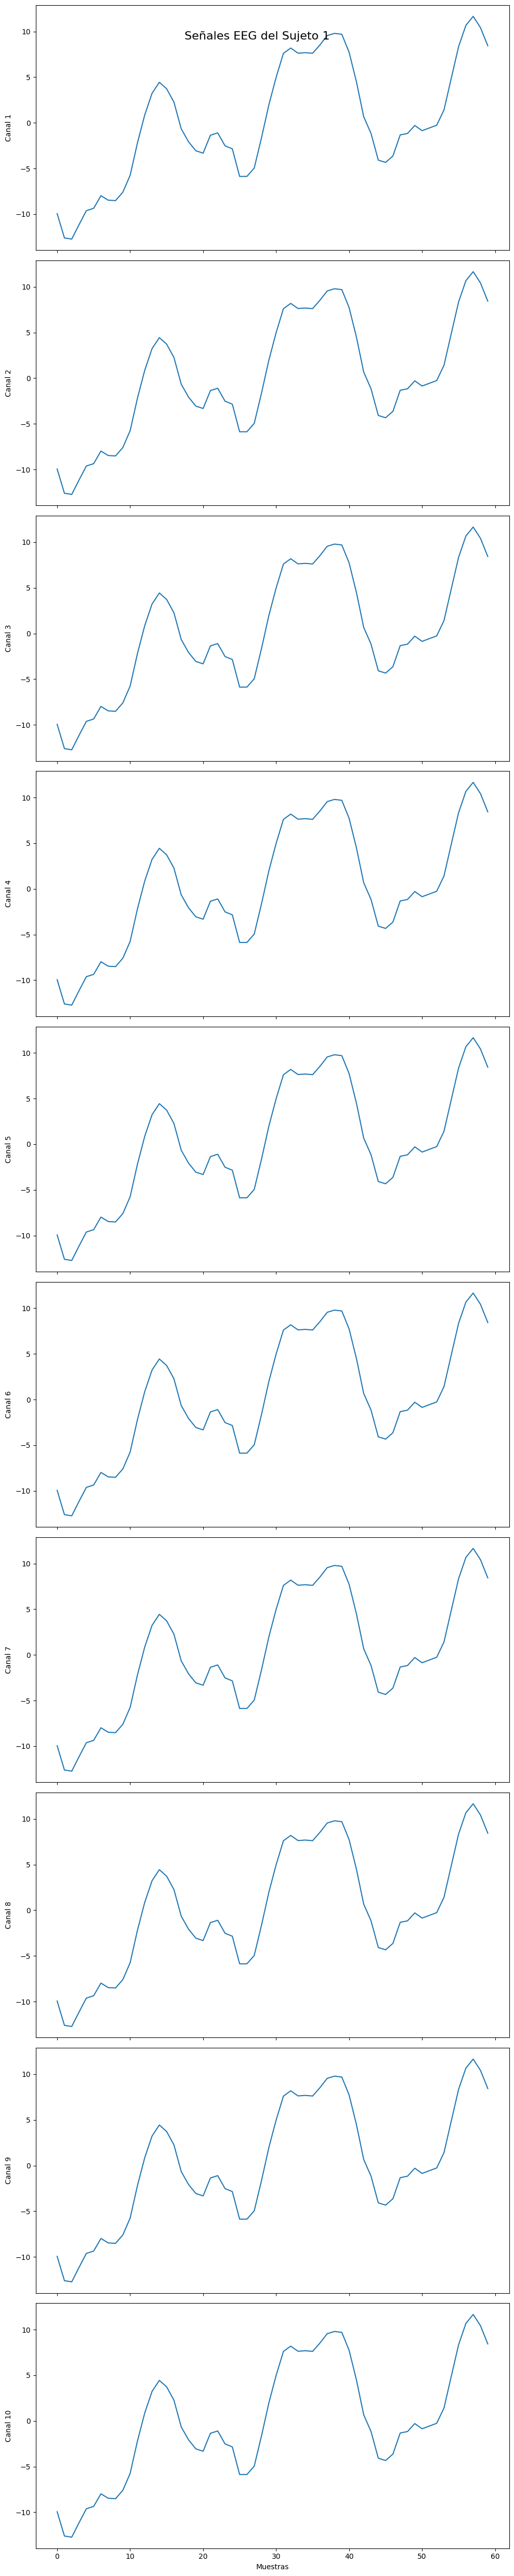

In [ ]:
plot_eeg_signals (1, synthetic_data)

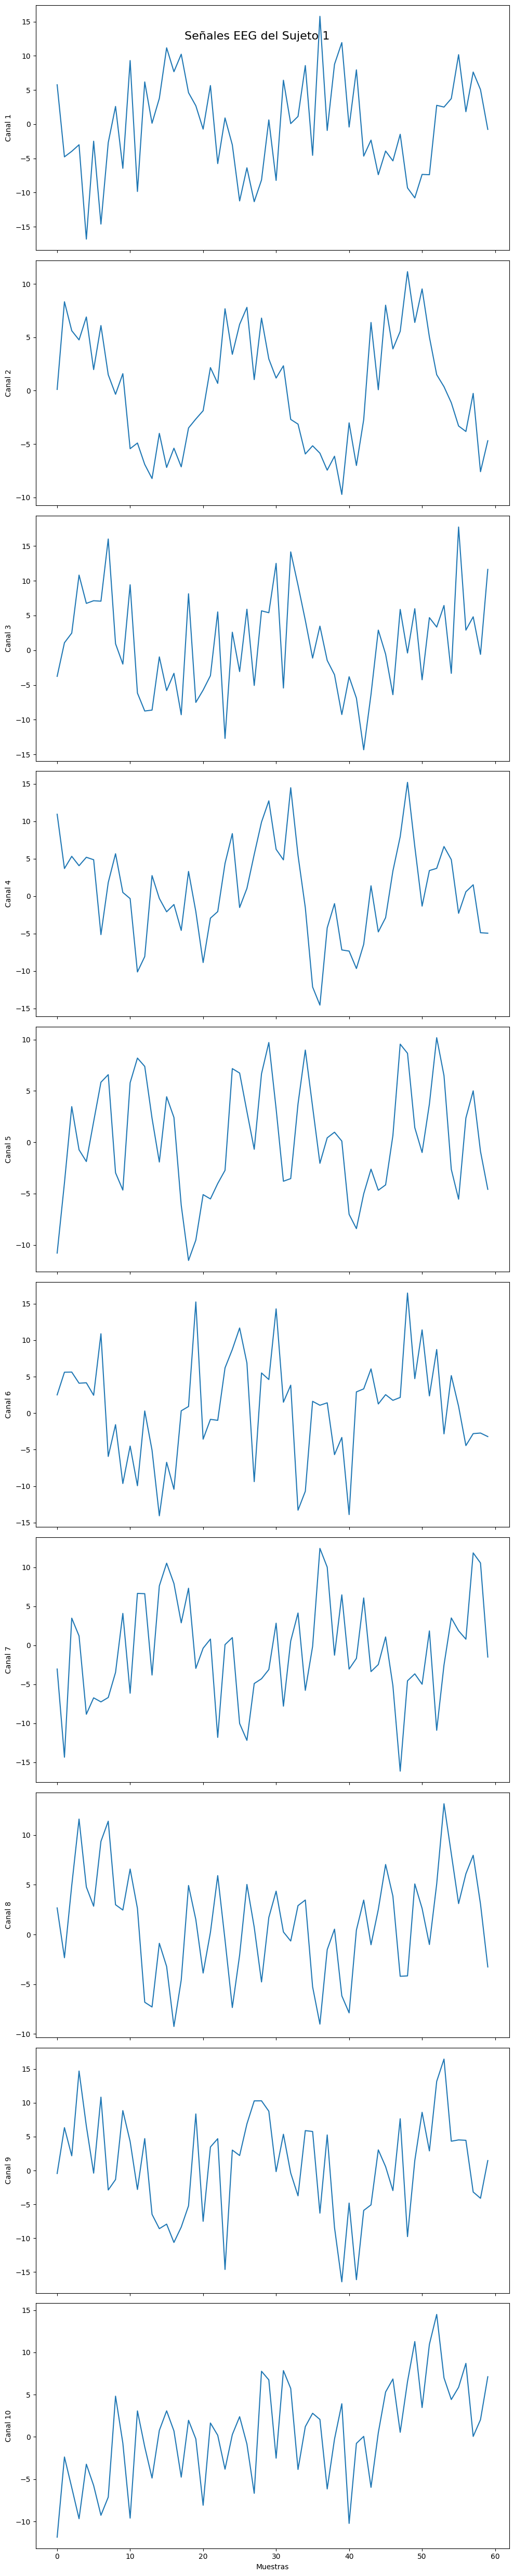

In [ ]:
plot_eeg_signals (1, synthetic_data_auto)

 # Cluster

In [93]:
config_clus  = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.01,
    'init_mean':0,
    'input_size':10,
    'n_internal_units': 480,
    'spectral_radius': 0.59,
    'leak': 0.4,
    'input_scaling':0.1,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.6,
    'noise_level': 0.1,
    'n_drop': 100,
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'use_output_bias':True,
    'use_bias':True,
    'readout_type': None,
    'plasticity_synaptic':None,
    'plasticity_intrinsic':None,
    'threshold':0.5,
    'readout_training': 'gd',
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'num_epochs': 2000,
    'mlp_layout': (10, 10),
    'w_l2': 0.001,
    'learning_rate':0.9,
    'max_depth':12,
    'n_estimators':100,
    'min_samples_split':1,
    'min_samples_leaf':1,
    'random_state':1,
    'w_ridge_embedding':1.0,
    'mts_rep':'reservoir',
    'bidir': True,
    'circle': False,
    'dimred_method': 'tenpca',
    'n_dim': 44,
    'plasticity_synaptic':'hebb', # 'hebb'.'oja', 'covariance'
    'theta_m':0.01,
    'plasticity_intrinsic':'excitability', # 'excitability', 'activation_function'
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}


config_clus_o = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.01,
    'init_mean':0,
    'input_size':10,
    'n_internal_units': 480,
    'spectral_radius': 0.59, # 0.59,
    'leak': 0.4, # 0.4,
    'input_scaling':0.1,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.6, # 0.6,
    'noise_level': 0.1,
    'n_drop': None, # 100
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'use_output_bias':True,
    'use_bias':True,
    'readout_type': None,
    'plasticity_synaptic':None,
    'plasticity_intrinsic':None,
    'threshold':0.5,
    'readout_training': 'gd',
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'num_epochs': 2000,
    'mlp_layout': (10, 10),
    'w_l2': 0.001,
    'learning_rate':0.9,
    'max_depth':12,
    'n_estimators':100,
    'min_samples_split':1,
    'min_samples_leaf':1,
    'random_state':1,
    'w_ridge_embedding':1.0,
    'mts_rep':'reservoir',
    'bidir': True,
    'circle': False,
    'dimred_method': 'tenpca',
    'n_dim': 44,
    'plasticity_synaptic':'hebb', # 'hebb'.'oja', 'covariance'
    'theta_m':0.01,
    'plasticity_intrinsic':'excitability', # 'excitability', 'activation_function'
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}

model_clus   = MyESN  (config_clus)
model_clus_o = MyESN  (config_clus_o)

reservoir_weights 0:cpu
reservoir_weights 1:cpu
reservoir_weights 2:cpu
reservoir_weights 3:cpu
mask 0:cpu
reservoir_weights 4:cpu
mask 1:cpu
reservoir_weights 0:cpu
reservoir_weights 1:cpu
reservoir_weights 2:cpu
reservoir_weights 3:cpu
mask 0:cpu
reservoir_weights 4:cpu
mask 1:cpu


In [94]:
X = synthetic_data
Y = labels
print("Dimensiones de los datos sintéticos X :", X.shape)
print("Dimensiones de las etiquetas Y:", Y.shape)
Xo = synthetic_data_auto
Y = labels
print("Dimensiones de los datos sintéticos Xo :", Xo.shape)
print("Dimensiones de las etiquetas Y:", Y.shape)

Dimensiones de los datos sintéticos X : (20, 1000, 10)
Dimensiones de las etiquetas Y: (20, 2)
Dimensiones de los datos sintéticos Xo : (20, 1000, 10)
Dimensiones de las etiquetas Y: (20, 2)


# Procesamos los datos sinteticos sin autorregresivo

In [95]:
my_rc_clus = MyRC (model_clus, config_clus )
result_rc  = my_rc_clus.fit (X)
output_rc_layer, mtx_output_rc_layer, reservoir_state, mtx_rc_state, input_repr, mtx_input_repr, red_states, mtx_red_states = result_rc

print (f'output_rc_layer:{output_rc_layer.shape}')
print (f'mtx_output_rc_layer:{mtx_output_rc_layer.shape}')
print (f'reservoir_state:{reservoir_state.shape}')
print (f'mtx_rc_state:{mtx_rc_state.shape}')
print (f'input_repr:{input_repr.shape}')
print (f'mtx_input_repr:{mtx_input_repr.shape}')
print (f'red_states:{red_states.shape}')
print (f'mtx_red_states:{mtx_red_states.shape}')

* self.mts_rep : reservoir
output_rc_layer:(20, 1980)
mtx_output_rc_layer:(20, 1980)
reservoir_state:(20, 2000, 480)
mtx_rc_state:(20, 1800, 480)
input_repr:(20, 1980)
mtx_input_repr:(20, 1980)
red_states:(20, 2000, 44)
mtx_red_states:(20, 1800, 44)


# Procesamos los datos sinteticos que contienen autorregresivo

In [96]:
my_rc_clus_o = MyRC (model_clus_o, config_clus_o )
result_rc_o  = my_rc_clus_o.fit (Xo)
output_rc_layer_o, mtx_output_rc_layer_o, reservoir_state_o, mtx_rc_state_o, input_repr_o, mtx_input_repr_o, red_states_o, mtx_red_states_o = result_rc_o

print ('* Xo :', Xo.shape)
print (f'output_rc_layer_o:{output_rc_layer_o.shape}')
print (f'mtx_output_rc_layer_o:{mtx_output_rc_layer_o.shape}')
print (f'reservoir_state_o:{reservoir_state_o.shape}')
print (f'mtx_rc_state_o:{mtx_rc_state_o.shape}')
print (f'input_repr_o:{input_repr_o.shape}')
print (f'mtx_input_repr_o:{mtx_input_repr_o.shape}')
print (f'red_states_o:{red_states_o.shape}')
print (f'mtx_red_states_o:{mtx_red_states_o.shape}')

* self.mts_rep : reservoir
* Xo : (20, 1000, 10)
output_rc_layer_o:(20, 1980)
mtx_output_rc_layer_o:(20, 1980)
reservoir_state_o:(20, 2000, 480)
mtx_rc_state_o:(20, 2000, 480)
input_repr_o:(20, 1980)
mtx_input_repr_o:(20, 1980)
red_states_o:(20, 2000, 44)
mtx_red_states_o:(20, 2000, 44)


# **Salidas del RC**



* Representacion interna del RC antes de la PCA:  [num sujets, num samples, num neuronas] o [num sujets, num samples, 2 x num neuronas]

  - Con todos los transitorios:**reservoir_state_o**
  - Eliminando los primeros transitorios: **mtx_rc_state_o**

* Representacion interna del RC despues de la PCA y antes de cambiar la representación interna:[num sujets, num samples, num reducción ndim]
  - Con todos los transitorios:**red_states_o**
  - Eliminando los primeros transitorios: **mtx_red_states_o**

* Representacion interna del RC despues de la PCA y representación interna, y antes del ReadOut: [num sujetos, num representación]
  - Con todos los transitorios:**input_repr_o**
  - Eliminando los primeros transitorios: **mtx_input_repr_o**

* Salida del RC despues de aplicar Ridge y Redaout (*):[num sujetos, num readout]
  - Con todos los transitorios:**output_rc_layer_o**
  - Eliminando los primeros transitorios: **mtx_output_rc_layer_o**

          (*) Si readout es None entonces
          output_rc_layer_o == input_repr_o
          mtx_output_rc_layer_o == mtx_input_repr_o  


In [97]:
model_clus.config

{'seed': 1,
 'init_type': 'orthogonal',
 'init_std': 0.01,
 'init_mean': 0,
 'input_size': 10,
 'n_internal_units': 480,
 'spectral_radius': 0.59,
 'leak': 0.4,
 'input_scaling': 0.1,
 'nonlinearity': 'relu',
 'connectivity': 0.6,
 'noise_level': 0.1,
 'n_drop': 100,
 'washout': 'init',
 'use_input_bias': True,
 'use_input_layer': True,
 'use_output_bias': True,
 'use_bias': True,
 'readout_type': None,
 'plasticity_synaptic': 'hebb',
 'plasticity_intrinsic': 'excitability',
 'threshold': 0.5,
 'readout_training': 'gd',
 'svm_kernel': 'linear',
 'svm_gamma': 0.005,
 'svm_C': 5.0,
 'w_ridge': 5.0,
 'num_epochs': 2000,
 'mlp_layout': (10, 10),
 'w_l2': 0.001,
 'learning_rate': 0.9,
 'max_depth': 12,
 'n_estimators': 100,
 'min_samples_split': 1,
 'min_samples_leaf': 1,
 'random_state': 1,
 'w_ridge_embedding': 1.0,
 'mts_rep': 'reservoir',
 'bidir': True,
 'circle': False,
 'dimred_method': 'tenpca',
 'n_dim': 44,
 'theta_m': 0.01,
 'new_activation_function': 'tanh',
 'excitability_facto

# Clusters Datos autorregresivos.

output_rc_layer_o:(20, 1980)


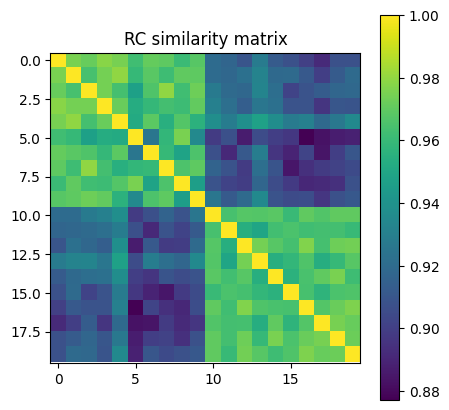

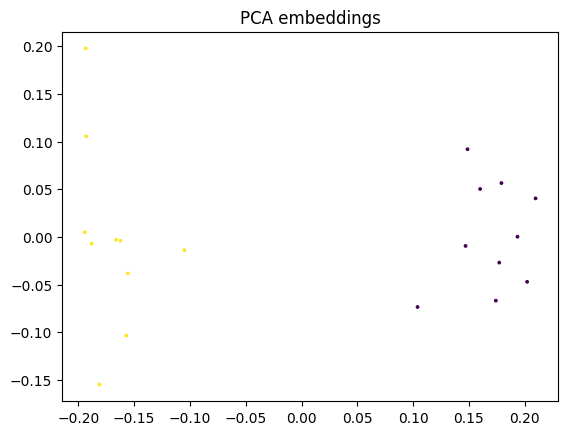

Found 2 clusters
Normalized Mutual Information (v-score): 1.000


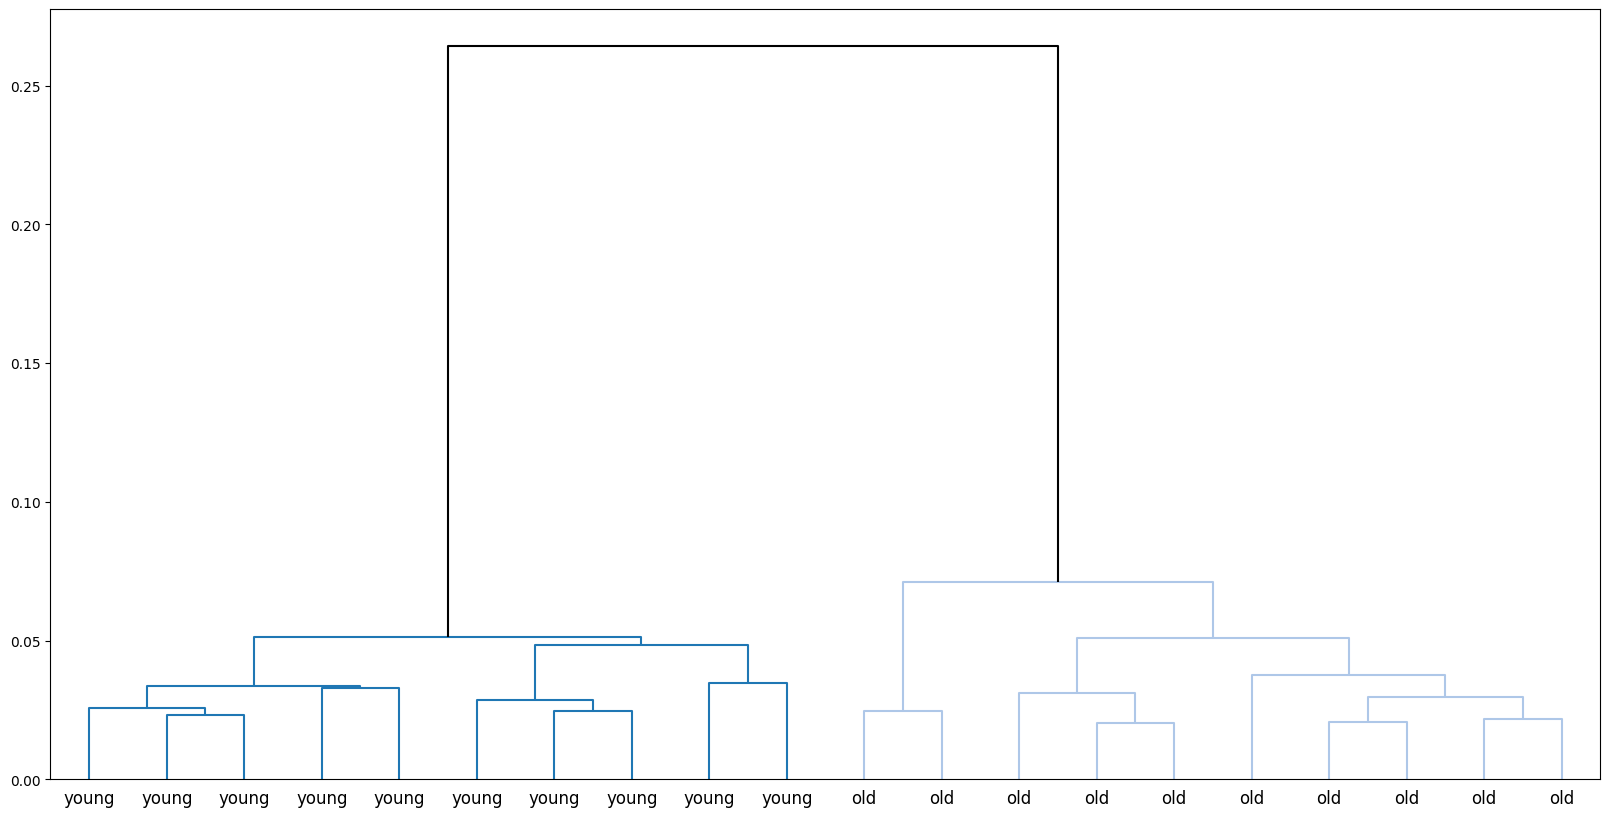

N. clusters:  2


In [98]:
# General imports
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score

# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)

print(f'output_rc_layer_o:{output_rc_layer_o.shape}')

mts_representations_o = output_rc_layer_o # Se pu7ede cambiar por: output_rc_layer_o, mtx_output_rc_layer_o
# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity (mts_representations_o)

# Normalize the similarity in [0,1]
similarity_matrix = (similarity_matrix + 1.0)/2.0

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

# Reducción de dimensionalidad con Kernel PCA
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(similarity_matrix)
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y[:,0], s=3)
plt.title("PCA embeddings")
plt.show()

# Compute Dissimilarity matrix
Dist = 1.0 - similarity_matrix
np.fill_diagonal(Dist, 0) # due to numerical errors, the diagonal might not be 0

# Hierarchical clustering
distArray = ssd.squareform (Dist)
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t = 0.2, criterion="distance")
print("Found %d clusters"%len(np.unique(clust)))
# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print("Normalized Mutual Information (v-score): %.3f"%nmi)

# Plot dendrogram
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=0.2, labels = words_labels, above_threshold_color='k')
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)

# Clusters sin autoregresivo y con diferentes amplitudes

output_rc_layer:(20, 1980)


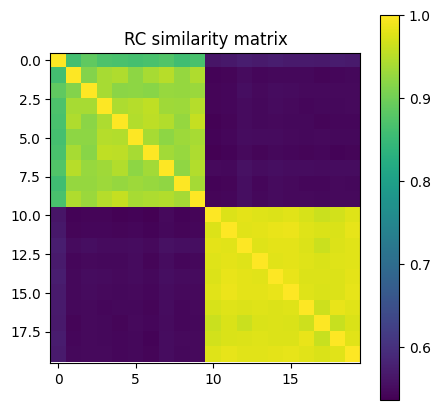

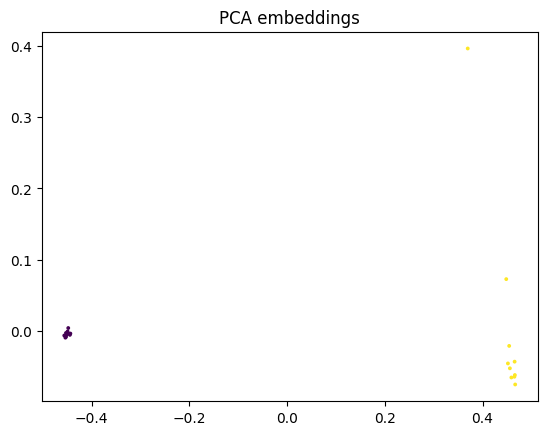

Found 2 clusters
Normalized Mutual Information (v-score): 1.000


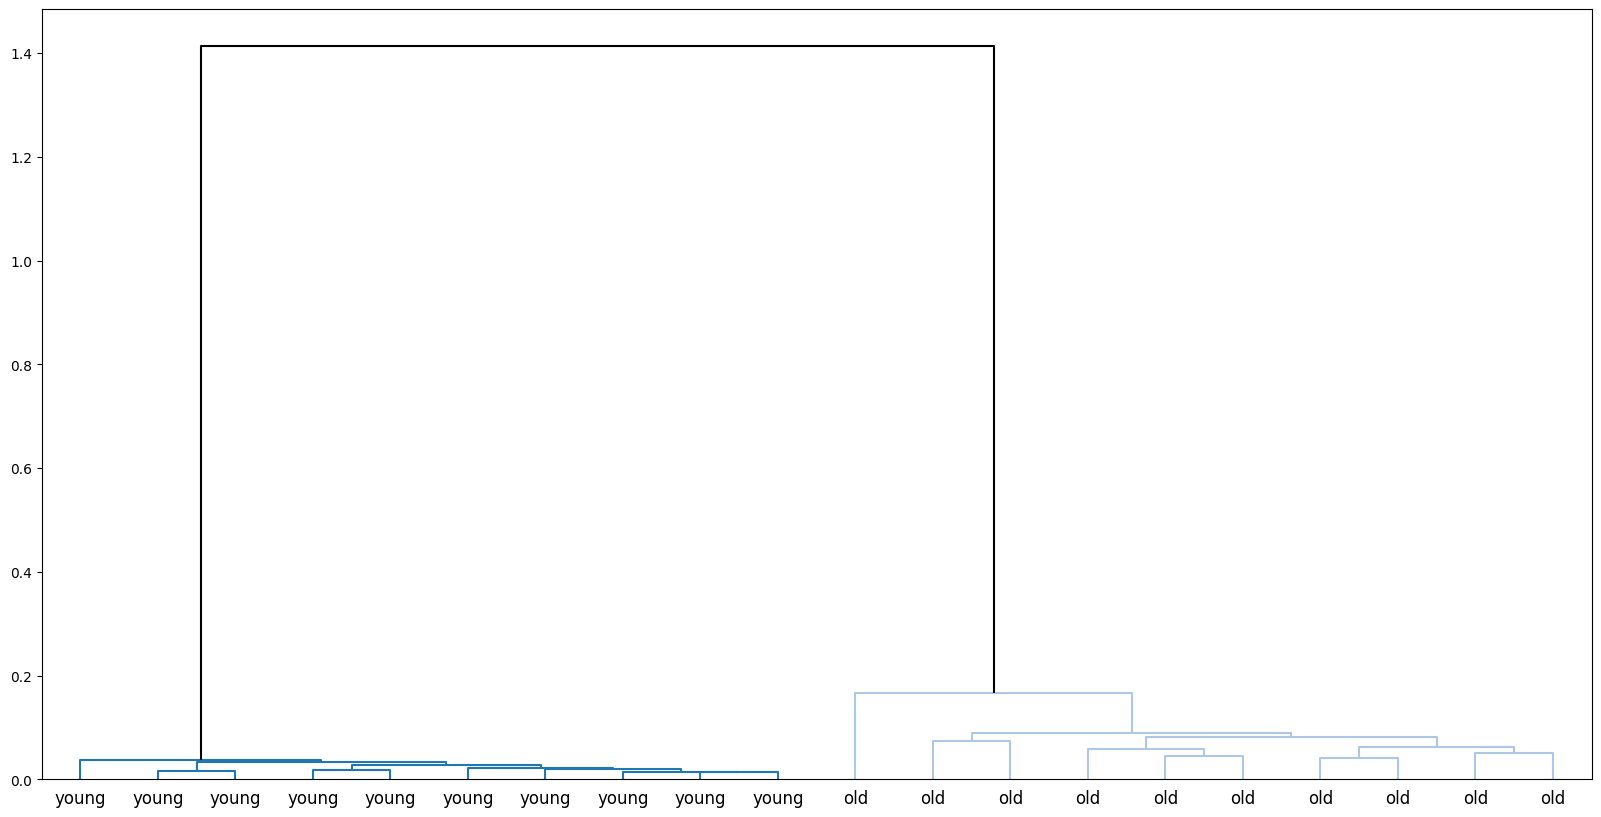

N. clusters:  2


In [99]:
# General imports
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score

# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)

print(f'output_rc_layer:{output_rc_layer.shape}')

mts_representations = output_rc_layer
# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity (mts_representations)

# Normalize the similarity in [0,1]
similarity_matrix = (similarity_matrix + 1.0)/2.0

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

# Reducción de dimensionalidad con Kernel PCA
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(similarity_matrix)
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y[:,0], s=3)
plt.title("PCA embeddings")
plt.show()

# Compute Dissimilarity matrix
Dist = 1.0 - similarity_matrix
np.fill_diagonal(Dist, 0) # due to numerical errors, the diagonal might not be 0

# Hierarchical clustering
distArray = ssd.squareform (Dist)
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t = 0.2, criterion="distance")
print("Found %d clusters"%len(np.unique(clust)))
# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print("Normalized Mutual Information (v-score): %.3f"%nmi)

# Plot dendrogram
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=0.2, labels = words_labels, above_threshold_color='k')
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)

# **Graficos de recurrencia**
Ahora se tienen los sujetyos sinteticos con misma ampitud (=1)

Se utiliza la representacion interna del RC antes del PCA.: reservoir_state_o

In [100]:
# Consolidar los estados del reservorio (por ejemplo, mediante promedio a través de canales)
S_t = np.mean (reservoir_state_o, axis=1)
S_t.shape

(20, 480)

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot

def plot_recurrence_for_subjects(data, thresholds=[0.1, 0.2, 0.3]):
    """
    Genera y visualiza una gráfica recurrente para cada sujeto en el dataset.

    :param data: numpy array de forma (n_sujetos, n_features), donde n_sujetos es el número de sujetos
                 y n_features es la representación interna del RC para cada sujeto.
    :param thresholds: lista de valores de umbral para la recurrencia.
    """
    n_subjects = data.shape[0]

    for subject_index in range(n_subjects):
        # Obtener los datos para el sujeto actual
        subject_data = data[subject_index]

        # Normalizar los datos del sujeto
        #subject_data_normalized = (subject_data - np.mean(subject_data)) / np.std(subject_data)

        for threshold in thresholds:
            # Creación de la gráfica recurrente con el umbral especificado
            rp = RecurrencePlot(subject_data.reshape(-1, 1), threshold=threshold)

            # Obtener la matriz de recurrencia
            recurrence_matrix = rp.recurrence_matrix()

            # Verificación de la matriz de recurrencia
            if np.sum(recurrence_matrix) == 0:
                print(f'La matriz de recurrencia para el sujeto {subject_index} con umbral {threshold} está vacía.')
                continue

            # Visualización de la gráfica recurrente
            plt.figure()
            plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
            plt.xlabel('Time')
            plt.ylabel('Time')
            plt.title(f'Recurrence Plot for Subject {subject_index} with Threshold {threshold}')
            plt.show()

# Ejemplo de uso con datos aleatorios (reemplaza esto con tus datos reales)

plot_recurrence_for_subjects(mts_representations_o, thresholds=[0.1]) #, 0.2, 0.3


In [ ]:
plot_recurrence_for_subjects(S_t, thresholds=[0.3])

Output hidden; open in https://colab.research.google.com to view.

# Comprobamos la reconstrucción de los canales y medimos la coherencia de las señales


La coherencia en el contexto del EEG se refiere a la medida de la sincronización o relación lineal entre las señales de dos canales diferentes en un mismo EEG. Esta medida puede ayudar a entender cómo están relacionadas las actividades neuronales entre distintas regiones del cerebro.

# Recosntruimos las señales

In [102]:
from sklearn.linear_model import Ridge

# Inicializar un diccionario para almacenar los modelos de regresión por canal y sujeto
ridge_models_tr = {}
ridge_models_pr = {}

mts_repesent = reservoir_state_o

n_all_sample  = mts_repesent.shape [1]
size_RC       = mts_repesent.shape [2]

n_subject     = X.shape [0]
n_samples     = X.shape [1]
n_channels    = X.shape [2]

X_orig = Xo
# Si bidireccional, duplicar y concatenar los datos de entrada
if config_clus_o ['bidir']:
    Xo_b = Xo [:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]

# Entrenar un modelo de regresión Ridge para cada canal y sujeto
for subject in range(n_subject):
    #print (f'* subject:{subject}')
    ridge_models_tr [subject] = {}  # Diccionario para modelos de entrenamiento
    ridge_models_pr [subject] = {}  # Diccionario para modelos de predicción
    for canal in range (n_channels):
        # print (f'* canal:{canal}')
        ridge_model_tr = Ridge(alpha = 1.0)                # Ajusta el parámetro alpha según sea necesario
        X_r = mts_repesent [subject].reshape (-1, size_RC)        # Las características son la representación RC aplanada
        y_r = X_orig [subject, :, canal].reshape (-1)   # La etiqueta es la señal para el canal actual
        # print (X.size())
        # print (y.size())
        ridge_model_tr.fit (X_r, y_r)
        ridge_models_tr [subject][canal] = ridge_model_tr

    #print (f'* canal:{canal}')
# Recosntruimos las señales
# Hacer predicciones para cada canal y sujeto
rec_subject_channel  = {}
for subject in range(n_subject):
    #print (f'* subject:{subject}')
    rec_subject_channel[subject]  = {}
    for canal in range(n_channels):
        model_s_c_tr  = ridge_models_tr [subject][canal]
        rec_subject_channel [subject][canal]  = model_s_c_tr.predict(mts_repesent [subject]).reshape (n_samples)
    #print (f'* canal:{canal}')


In [103]:

# Convertimos el diccionario en un array tridimensional
rep_eeg = np.array([[[value for value in channel] for channel in subject.values()] for subject in rec_subject_channel.values()])
print (rep_eeg.shape)


(20, 10, 2000)


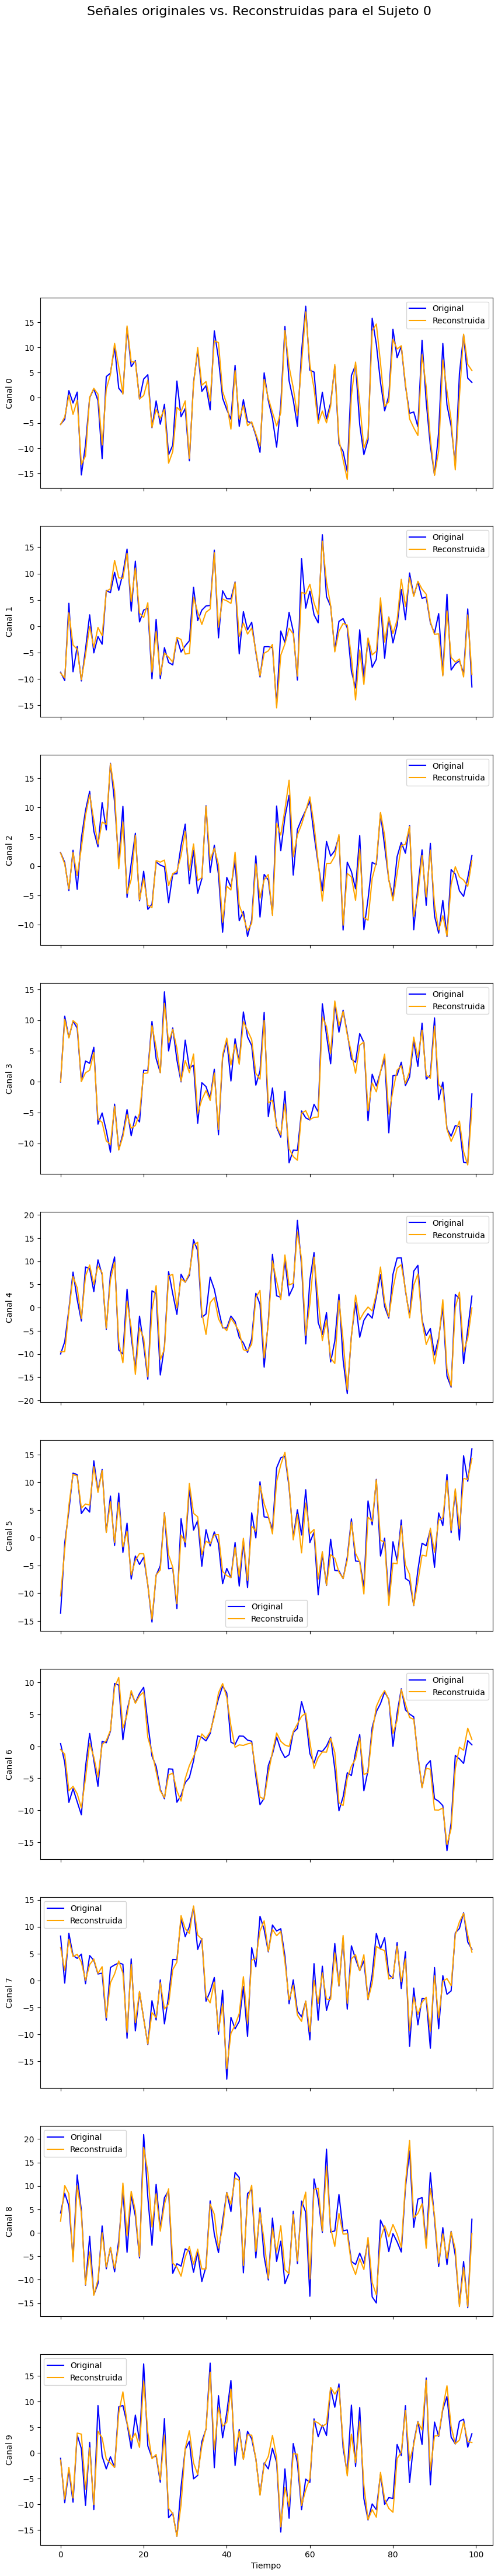

In [104]:
import matplotlib.pyplot as plt

def plot_signals_original_vs_reconstructed(original_signals, reconstructed_signals):


    fig, axs = plt.subplots(n_channels, 1, figsize=(10, 5*n_channels), sharex=True)
    fig.suptitle(f'Señales originales vs. Reconstruidas para el Sujeto {subject_index}', fontsize=16)

    for i in range(n_channels):
        original_signal      = original_signals [:100, i]
        rec_signal = reconstructed_signals[i, :100]

        axs[i].plot(original_signal, label='Original', color='blue')
        axs[i].plot(rec_signal, label='Reconstruida', color='orange')
        axs[i].set_ylabel(f'Canal {i}')
        axs[i].legend()

    plt.xlabel('Tiempo')
    plt.show()

#################
subject_index = 0
eeg_o = Xo [subject_index]
eeg_r = rep_eeg [subject_index]
plot_signals_original_vs_reconstructed (eeg_o,eeg_r )

# Calculamos la coherencia para las señales reconstruidas..

config_clus_o ['bidir']:True
eeg_o.shape: (2000, 10)
eeg_o: (10, 2000)
eeg_r: (10, 2000)
Cxy average for channel 0: 0.5814154921849485
Cxy shape: (129,)
f shape: (129,)


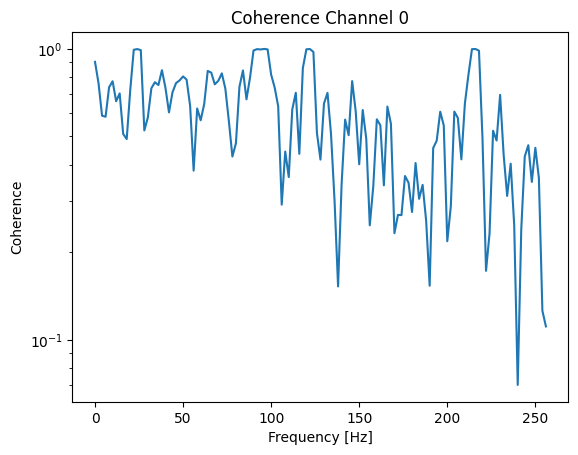

Cxy average for channel 1: 0.7215189179447229
Cxy shape: (129,)
f shape: (129,)


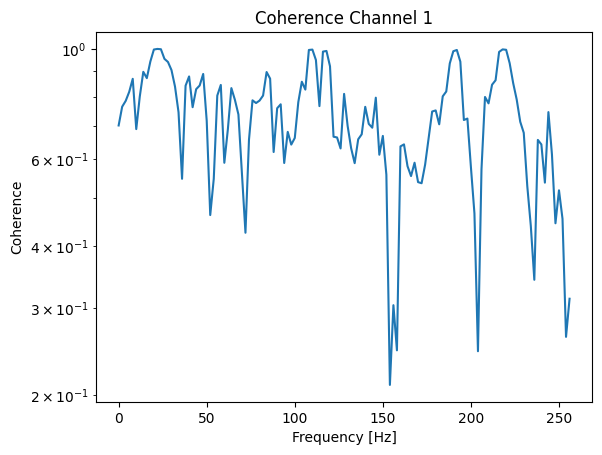

Cxy average for channel 2: 0.7088951944252403
Cxy shape: (129,)
f shape: (129,)


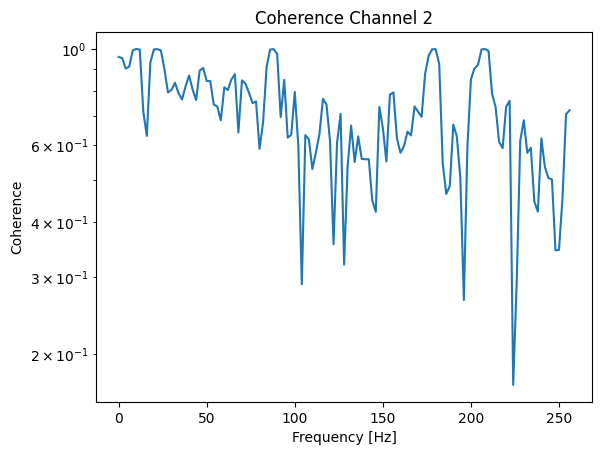

Cxy average for channel 3: 0.7150682658327522
Cxy shape: (129,)
f shape: (129,)


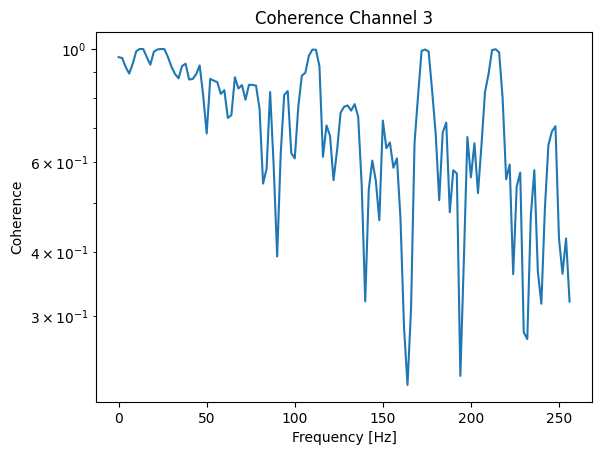

Cxy average for channel 4: 0.6147277941980778
Cxy shape: (129,)
f shape: (129,)


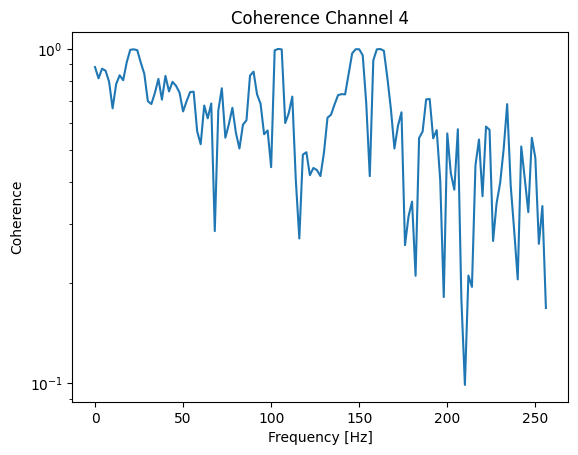

Cxy average for channel 5: 0.6584187088810409
Cxy shape: (129,)
f shape: (129,)


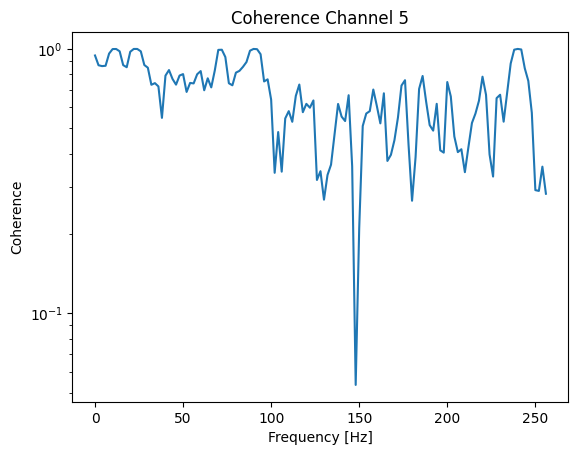

Cxy average for channel 6: 0.7124912046680937
Cxy shape: (129,)
f shape: (129,)


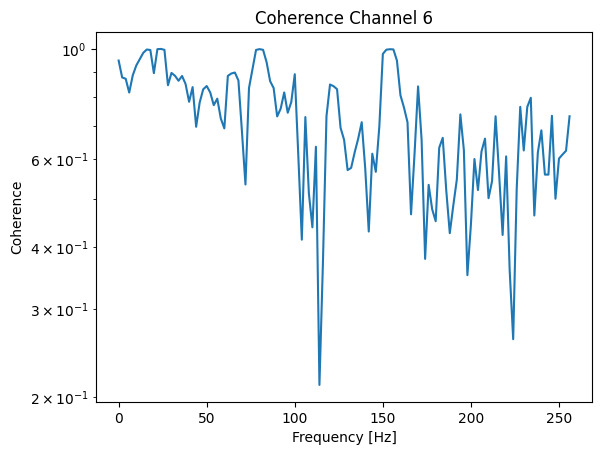

Cxy average for channel 7: 0.6915140739314375
Cxy shape: (129,)
f shape: (129,)


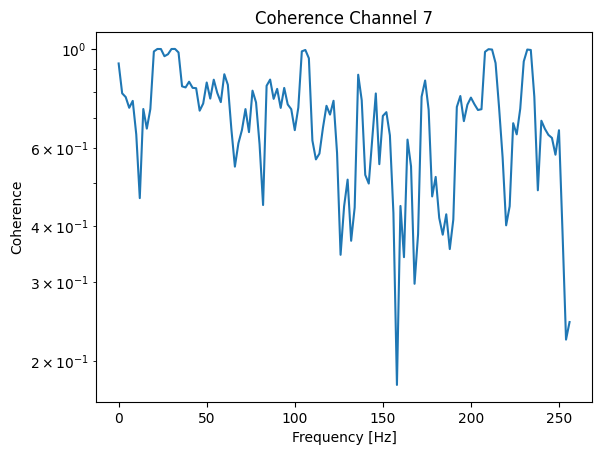

Cxy average for channel 8: 0.5850059110025091
Cxy shape: (129,)
f shape: (129,)


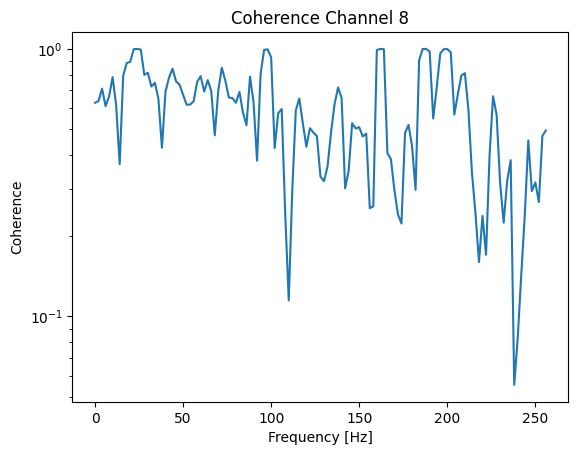

Cxy average for channel 9: 0.6162412798915464
Cxy shape: (129,)
f shape: (129,)


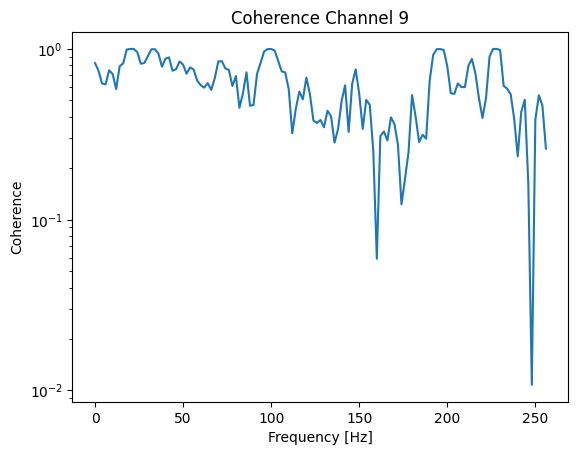

Coherencia promedio entre todos los canales: 0.8124936808197025


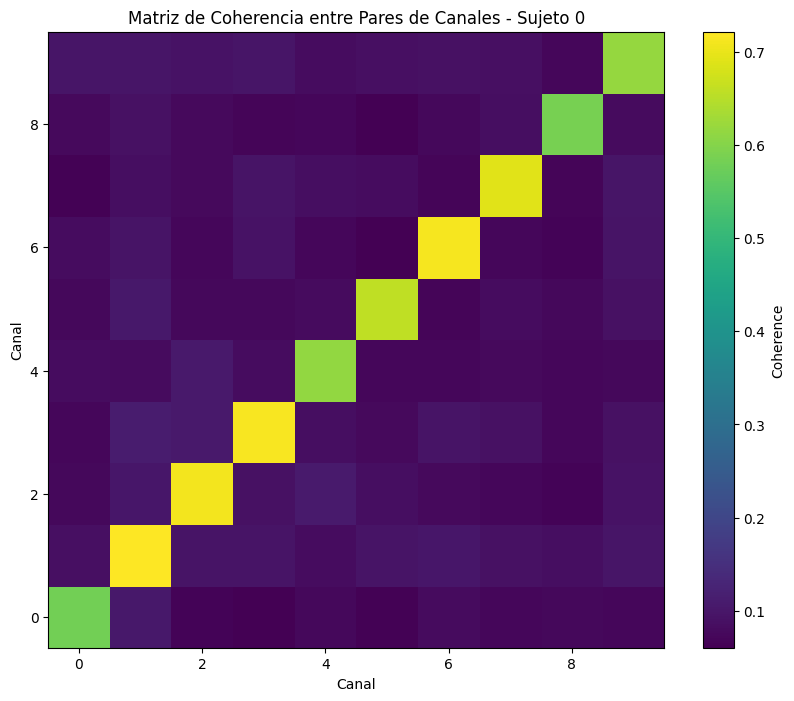

In [105]:
import numpy as np
from scipy.signal import coherence
import matplotlib.pyplot as plt

# Definir bandas de frecuencia
bandas_frecuencia = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 100)
}

def create_coherence_matrix(eeg_o, eeg_r, fs=512, nperseg=256):
    n_channels = eeg_o.shape[0]
    coherence_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(n_channels):
            f, Cxy = coherence(eeg_o[i, :], eeg_r[j, :], fs=fs, nperseg=nperseg)
            # Aquí se podría promediar en una banda de frecuencias específica
            coherence_matrix[i, j] = np.mean(Cxy)  # Promedio sobre todas las frecuencias
    return coherence_matrix

def create_coherence_original_vs_reconstructed(eeg_o, eeg_r, fs=512, nperseg=256, banda=None):
    n_channels = eeg_o.shape[0]
    print(f'eeg_o: {eeg_o.shape}')
    print(f'eeg_r: {eeg_r.shape}')
    cohe = []

    for i in range(n_channels):
        f, Cxy = coherence(eeg_o[i, :], eeg_r[i, :], fs=fs, nperseg=nperseg)
        if banda:
            # Filtrar coherencia en la banda de frecuencia específica
            idx_band = np.where((f >= banda[0]) & (f <= banda[1]))
            Cxy_band = Cxy[idx_band]
            cohe.append(np.mean(Cxy_band))
        else:
            cohe.append(np.mean(Cxy))  # Promedio de coherencia en todas las frecuencias

        print(f"Cxy average for channel {i}: {np.mean(Cxy)}")
        print(f"Cxy shape: {Cxy.shape}")
        print(f"f shape: {f.shape}")

        # Graficar la coherencia
        plt.figure()
        plt.semilogy(f, Cxy)
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Coherence')
        plt.title(f'Coherence Channel {i}')
        plt.show()

    return cohe

# Si bidireccional, duplicar y concatenar los datos de entrada
print(f"config_clus_o ['bidir']:{config_clus_o['bidir']}")
X_orig = Xo
if config_clus_o['bidir']:
    Xo_b = Xo[:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]

subject_index = 0
eeg_o = X_orig[subject_index]
print(f'eeg_o.shape: {eeg_o.shape}')

# Intercambio de valores
eeg_o = eeg_o.T
eeg_r = rep_eeg[subject_index]

# Calcular la coherencia para el sujeto en una banda específica (por ejemplo, Alpha)
banda = bandas_frecuencia['Alpha']
coherence_subject = create_coherence_original_vs_reconstructed(eeg_o, eeg_r, banda=banda)

# Calcular la coherencia promedio
average_coherence = np.mean(coherence_subject)
print("Coherencia promedio entre todos los canales:", average_coherence)

# Crear la matriz de coherencia
coherence_matrix = create_coherence_matrix(eeg_o, eeg_r)

# Graficar el mapa de calor (heatmap) de la matriz de coherencia
plt.figure(figsize=(10, 8))
plt.imshow(coherence_matrix, cmap='viridis', origin='lower')
plt.colorbar(label='Coherence')
plt.title(f'Matriz de Coherencia entre Pares de Canales - Sujeto {subject_index}')
plt.xlabel('Canal')
plt.ylabel('Canal')
plt.grid(False)
plt.show()


# Información mutua entre canales originales y recosntruidos para cada sujeto

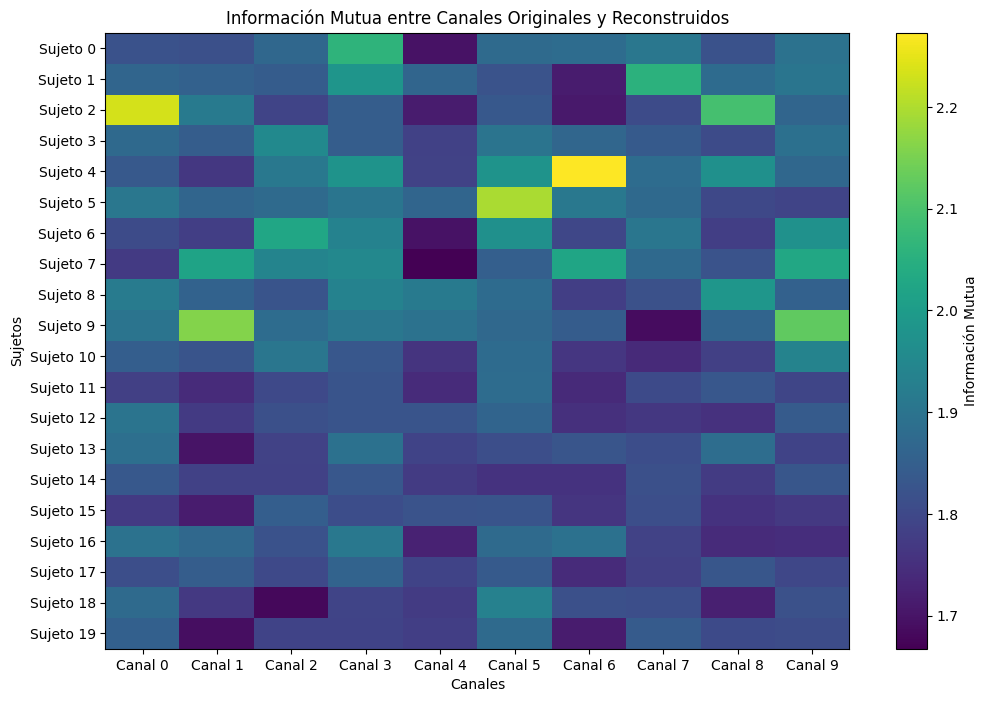

In [106]:
import numpy as np
import matplotlib.pyplot as plt

def mutual_information(original_signals, reconstructed_signals):
    mutual_info_values = []
    for i in range(original_signals.shape[1]):
        # Calcula las histogramas conjuntos y marginales para el par de canales actual
        joint_hist, _, _ = np.histogram2d(original_signals[:, i], reconstructed_signals[:, i], bins=20)
        pxy = joint_hist / np.sum(joint_hist)
        px = np.sum(pxy, axis=1)
        py = np.sum(pxy, axis=0)

        # Calcula la información mutua para el par de canales actual
        Hxy = -np.sum(pxy * np.log2(pxy + (pxy == 0)))
        Hx = -np.sum(px * np.log2(px + (px == 0)))
        Hy = -np.sum(py * np.log2(py + (py == 0)))
        mutual_info = Hx + Hy - Hxy
        mutual_info_values.append(mutual_info)
    return mutual_info_values

def plot_mutual_info_heatmap(mutual_info_matrix, channel_labels=None, subject_labels=None):
    """
    Crea un mapa de calor para visualizar la información mutua entre canales originales y reconstruidos para cada sujeto.

    Args:
    - mutual_info_matrix (numpy.ndarray): Matriz de información mutua. Debe tener la forma (n_subjects, n_channels).
    - channel_labels (list): Lista de etiquetas para los canales. Debe tener longitud n_channels.
    - subject_labels (list): Lista de etiquetas para los sujetos. Debe tener longitud n_subjects.

    Returns:
    - None
    """
    n_subjects, n_channels = mutual_info_matrix.shape

    # Definir etiquetas para los ejes x e y si no se proporcionan
    if channel_labels is None:
        channel_labels = [f'Canal {i}' for i in range(n_channels)]
    if subject_labels is None:
        subject_labels = [f'Sujeto {i}' for i in range(n_subjects)]

    # Crear el mapa de calor
    plt.figure(figsize=(12, 8))
    plt.imshow(mutual_info_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Información Mutua')
    plt.title('Información Mutua entre Canales Originales y Reconstruidos')
    plt.xlabel('Canales')
    plt.ylabel('Sujetos')
    plt.xticks(np.arange(n_channels), channel_labels)
    plt.yticks(np.arange(n_subjects), subject_labels)
    plt.show()

# IM para los canales originales y reconstruidos
fs = 512  # Frecuencia de muestreo (solo necesario para el cálculo del error de fase)

n_subjects = Xo.shape [0]
X_orig = Xo
if config_clus_o['bidir']:
    Xo_b = Xo[:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]
# Matriz para almacenar los valores de información mutua para cada sujeto y canal
mutual_info_matrix = np.zeros((n_subjects, n_channels))
for idx_subject in range (n_subjects):
    EEG_O = X_orig [idx_subject]
    EEG_R = rep_eeg [idx_subject]
    EEG_R = np.array (np.swapaxes(EEG_R, 0, 1))
    mutual_info_matrix [idx_subject] = mutual_information(EEG_O, EEG_R)

n_channels = EEG_O.shape [1]  # Número de canales
plot_mutual_info_heatmap(mutual_info_matrix)

La verdad que la IM no me da ninguna información porque no tengo una mediada de referencia que me indique la bondad de la recosntrucción. No se si el hecho de que todos sean myores a 1.4 es bueno o no...--123--

# Error de fase entre canales originales y recosntruidos para cada sujeto

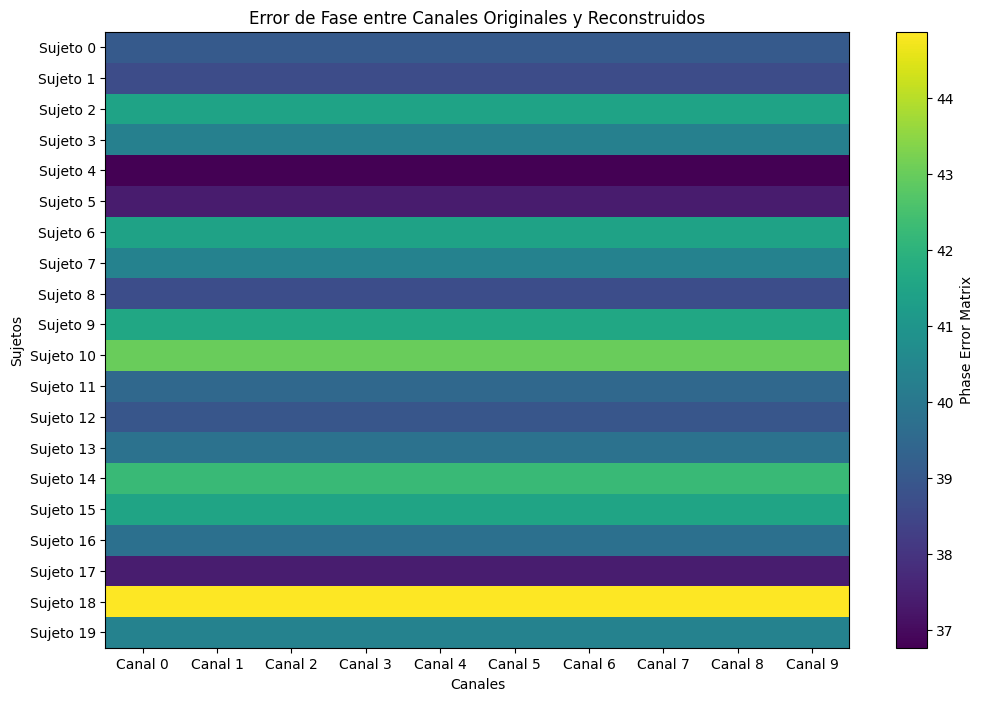

In [107]:
import numpy as np
import matplotlib.pyplot as plt

def phase_error(original_signal, reconstructed_signal, fs):
    # Calcula la FFT de las señales
    fft_original = np.fft.fft(original_signal)
    fft_reconstructed = np.fft.fft(reconstructed_signal)

    # Calcula la diferencia de fase
    phase_original = np.angle(fft_original)
    phase_reconstructed = np.angle(fft_reconstructed)
    phase_diff = phase_original - phase_reconstructed

    # Convierte la diferencia de fase a radianes y calcula el error medio
    phase_diff_radians = np.unwrap(phase_diff)
    phase_error = np.abs(phase_diff_radians) * (180 / np.pi)  # Convertir a grados
    mean_phase_error = np.mean(phase_error)
    return mean_phase_error



def plot_phase_error_heatmap (phase_error_matrix, channel_labels = None, subject_labels = None):
    """
    Crea un mapa de calor para visualizar la información mutua entre canales originales y reconstruidos para cada sujeto.

    Args:
    - phase_error_matrix (numpy.ndarray): Matriz de error de fase. Debe tener la forma (n_subjects, n_channels).
    - channel_labels (list): Lista de etiquetas para los canales. Debe tener longitud n_channels.
    - subject_labels (list): Lista de etiquetas para los sujetos. Debe tener longitud n_subjects.

    Returns:
    - None
    """
    n_subjects, n_channels = mutual_info_matrix.shape

    # Definir etiquetas para los ejes x e y si no se proporcionan
    if channel_labels is None:
        channel_labels = [f'Canal {i}' for i in range(n_channels)]
    if subject_labels is None:
        subject_labels = [f'Sujeto {i}' for i in range(n_subjects)]

    # Crear el mapa de calor
    plt.figure(figsize=(12, 8))
    plt.imshow(phase_error_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Phase Error Matrix')
    plt.title('Error de Fase entre Canales Originales y Reconstruidos')
    plt.xlabel('Canales')
    plt.ylabel('Sujetos')
    plt.xticks(np.arange(n_channels), channel_labels)
    plt.yticks(np.arange(n_subjects), subject_labels)
    plt.show()

# IM para los canales originales y reconstruidos
sr = 512  # Frecuencia de muestreo (solo necesario para el cálculo del error de fase)

n_subjects = Xo.shape [0]
X_orig = Xo
if config_clus_o['bidir']:
    Xo_b = Xo[:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]
# Matriz para almacenar los valores de phase error para cada sujeto y canal
phase_error_matrix = np.zeros((n_subjects, n_channels))
for idx_subject in range (n_subjects):
    EEG_O = X_orig [idx_subject]
    EEG_R = rep_eeg [idx_subject]
    EEG_R = np.array (np.swapaxes(EEG_R, 0, 1))
    phase_error_matrix [idx_subject] = phase_error (EEG_O, EEG_R, sr)

n_channels = EEG_O.shape [1]  # Número de canales
plot_phase_error_heatmap (phase_error_matrix)

In [ ]:


def mean_squared_error(original_signal, reconstructed_signal):
    mse = np.mean((original_signal - reconstructed_signal) ** 2)
    return mse

def mean_absolute_error(original_signal, reconstructed_signal):
    mae = np.mean(np.abs(original_signal - reconstructed_signal))
    return mae

In [ ]:
n_subjects = Xo.shape [0]
X_orig = Xo
if config_clus_o['bidir']:
    Xo_b = Xo[:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]
# Matriz para almacenar los valores de phase error para cada sujeto y canal
phase_error_matrix = np.zeros((n_subjects, n_channels))
for idx_subject in range (n_subjects):
    print("* Subject:", idx_subject)
    EEG_O = X_orig [idx_subject]
    EEG_R = rep_eeg [idx_subject]
    EEG_R = np.array (np.swapaxes (EEG_R, 0, 1))

    mse_value = mean_squared_error (EEG_O, EEG_R)
    mae_value = mean_absolute_error (EEG_O, EEG_R)

    print("\t\t - Mean Squared Error (MSE):", mse_value)
    print("\t\t - Mean Absolute Error (MAE):", mae_value)


* Subject: 0
		 - Mean Squared Error (MSE): 3.2043018513959103
		 - Mean Absolute Error (MAE): 1.4234723642931295
* Subject: 1
		 - Mean Squared Error (MSE): 2.9419818506227524
		 - Mean Absolute Error (MAE): 1.377156649295473
* Subject: 2
		 - Mean Squared Error (MSE): 2.9024146614635864
		 - Mean Absolute Error (MAE): 1.3618592557942533
* Subject: 3
		 - Mean Squared Error (MSE): 3.178673176040794
		 - Mean Absolute Error (MAE): 1.4288944938841164
* Subject: 4
		 - Mean Squared Error (MSE): 2.5419868220380066
		 - Mean Absolute Error (MAE): 1.2688720468958614
* Subject: 5
		 - Mean Squared Error (MSE): 3.0559852646081147
		 - Mean Absolute Error (MAE): 1.3869104623129598
* Subject: 6
		 - Mean Squared Error (MSE): 3.01527290674603
		 - Mean Absolute Error (MAE): 1.3831608781400446
* Subject: 7
		 - Mean Squared Error (MSE): 3.050186535399032
		 - Mean Absolute Error (MAE): 1.3892156505608484
* Subject: 8
		 - Mean Squared Error (MSE): 3.115184832571624
		 - Mean Absolute Error (MAE):

# Clustering  y metodos no supervisados

my_rc.input_repr:(20, 1980)


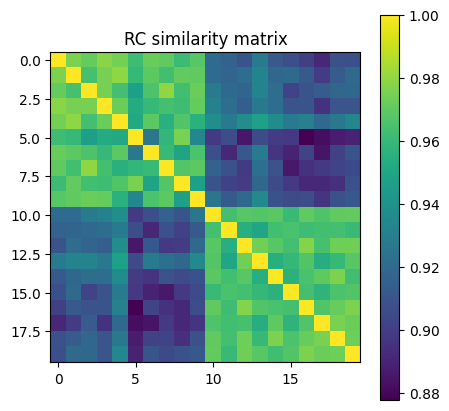

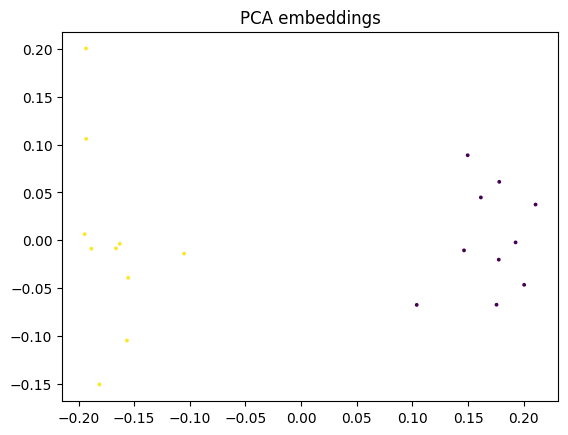

Found 2 clusters
Normalized Mutual Information (v-score): 1.000


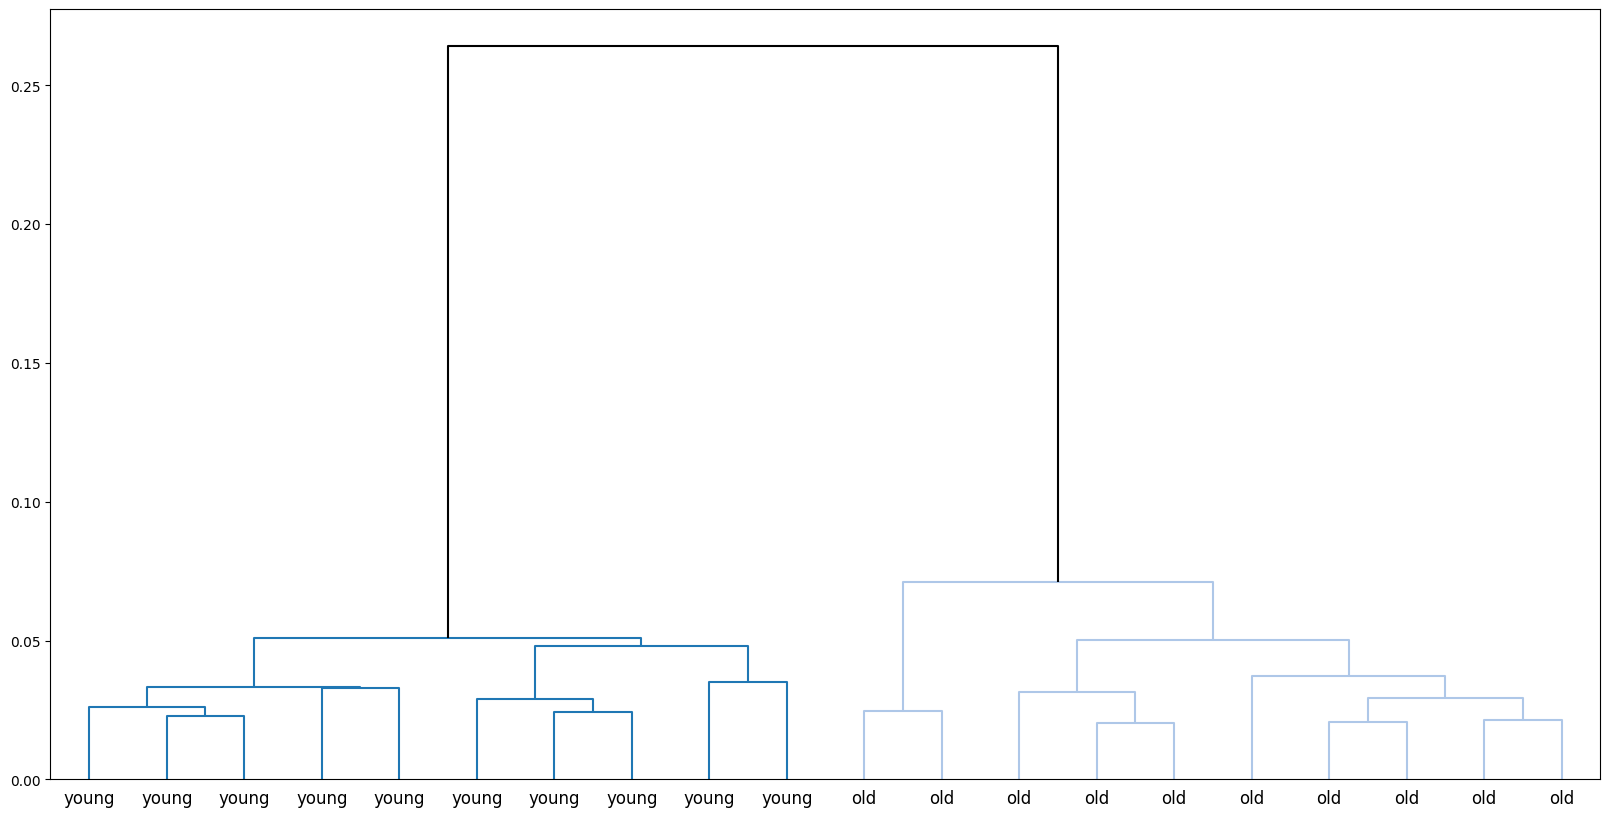

N. clusters:  2


In [ ]:
# General imports
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score

# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)

print(f'my_rc.input_repr:{my_rc_clus.input_repr.shape}')

mts_representations = output_rc_layer_o
# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity (mts_representations)

# Normalize the similarity in [0,1]
similarity_matrix = (similarity_matrix + 1.0)/2.0

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

# Reducción de dimensionalidad con Kernel PCA
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(similarity_matrix)
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y[:,0], s=3)
plt.title("PCA embeddings")
plt.show()

# Compute Dissimilarity matrix
Dist = 1.0 - similarity_matrix
np.fill_diagonal(Dist, 0) # due to numerical errors, the diagonal might not be 0

# Hierarchical clustering
distArray = ssd.squareform (Dist)
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t = 0.2, criterion="distance")
print("Found %d clusters"%len(np.unique(clust)))
# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print("Normalized Mutual Information (v-score): %.3f"%nmi)

# Plot dendrogram
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=0.2, labels = words_labels, above_threshold_color='k')
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)




# GRAFICOS DE RECURRENCIA

Comprobaremos si la representación interna del RC recoge las características o patrones de la dinámica temporal de lsas señales temporales de los canales EEG de cada sujeto.

La idea es conprobar si existen unos patrones similares entre sujetos jovenes adultos y distintivos entre éstos y los sujetos mayores.

Para el cálculo de las gráficas de recurrencia utilizarémos dos alternativas:

*{¿Qué es una Gráfica Recurrente?}*

Una gráfica recurrente es una representación bidimensional que muestra los momentos en los que un sistema dinámico retorna a estados similares. Se basa en el concepto de "recurrencia", que es la tendencia de los sistemas dinámicos a visitar los mismos estados o estados similares a lo largo del tiempo.

*{Definición Formal}*

Para una serie temporal $(\{x_i\}_{i=1}^N)$, la gráfica recurrente se define como una matriz $(R)$ donde cada elemento $(R_{i,j})$ se determina de la siguiente manera:

$$
R_{i,j} = \Theta (\epsilon - \| \mathbf{x}_i - \mathbf{x}_j \|)
$$

Aquí:

* $(mathbf{x}_i)$ y $(mathbf{x}_j)$ son los puntos en el espacio de fases (generalmente reconstruido mediante el método de retardos).
* $(| \cdot \|)$ es una norma (comúnmente la norma euclidiana).
* $(\epsilon)$ es un umbral de recurrencia.
* $(\Theta)$ es la función escalón de Heaviside, que es 1 si el argumento es positivo y 0 en caso contrario.


*{Cómo se Utiliza una Gráfica Recurrente}*


* *{Reconstrucción del Espacio de Fases}*: Si los datos originales están en una serie temporal unidimensional, se reconstruye el espacio de fases utilizando el método de retrasos (delay embedding).
    
  $$
  \mathbf{x}(t) = [x(t), x(t+\tau), x(t+2\tau), \dots, x(t+(m-1)\tau)]
  $$
  
  Donde $(\tau)$ es el retraso de tiempo y $(m)$ es la dimensión de incrustación.
    
* **{Construcción de la Matriz de Recurrencia}**: Con el espacio de fases reconstruido, se calcula la matriz de recurrencia usando la definición mencionada.
    
* **Visualización}**: La matriz de recurrencia se visualiza como una imagen donde los valores de 1 (o verdaderos) se representan como puntos negros y los valores de 0 (o falsos) se representan como puntos blancos.


*{Interpretación de las Gráficas Recurrentes}*


* **{Diagonales}**: Indican que el sistema sigue un patrón similar en el tiempo, mostrando periodicidad o recurrencia.
* **{Verticales/Horizontales}**: Sugieren estados estacionarios o lentos cambios en la dinámica.
* **{Blancos}**: Áreas sin recurrencia, indicando transiciones o cambios en el estado del sistema.
* **{Estructuras complejas}**: Pueden revelar dinámicas caóticas o comportamientos no lineales complejos.


*{Aplicaciones}*


* **{Análisis de Sistemas Dinámicos}**: Útil en física, biología y economía para estudiar sistemas caóticos y complejos.
* **{Medicina}**: Análisis de señales fisiológicas, como electrocardiogramas (ECG) o electroencefalogramas (EEG).
* **{Climatología}**: Estudio de patrones climáticos y detección de cambios en el clima.
* **{Ingeniería}**: Análisis de vibraciones y detección de fallos en maquinaria.


*{Herramientas y Software}*

Existen varias herramientas y software para generar y analizar gráficas recurrentes, tales como:


* **{Matlab}**: Posee funciones específicas para crear gráficas recurrentes.
* **{Python}**: Bibliotecas como {pyunicorn} y {recurrence\_plot} en {scikit-mobility} pueden ser utilizadas.
* **{R}**: Paquetes como \texttt{tseriesChaos} ofrecen funciones para análisis de series temporales y gráficas recurrentes.


***{Pasos Generales}***


* **{Obtener la salida de tu ESN}**: Ejecuta tu ESN para obtener la serie temporal de salida que deseas analizar.

* **{Formatear los datos}**: Asegúrate de que los datos están en el formato adecuado (array de Numpy, por ejemplo).

* **{Crear la gráfica recurrente}**: Utiliza {RecurrencePlot} de {pyunicorn} o {recurrence\_plot} de {scikit-mobility} para generar la gráfica recurrente.

* **{Visualizar y analizar}**: Usa funciones de visualización (como {plot()} en {pyunicorn} o {plt.imshow()} en {scikit-mobility}) para visualizar la gráfica recurrente y analizar los patrones.


***{Interpretación de las Gráficas Recurrentes}***

Una vez generada la gráfica recurrente, puedes buscar patrones como:

* **{Diagonales}**: Indican períodos de recurrencia y pueden sugerir periodicidad.
* **{Estructuras complejas}**: Indican comportamiento caótico o no lineal.
* **{Áreas blancas}**: Representan transiciones entre diferentes estados.
$$

***{Conclusión}***

Utilizar gráficas recurrentes con la salida de tu ESN es una excelente manera de visualizar y analizar los patrones dinámicos en tus señales temporales. \texttt{pyunicorn} y \texttt{scikit-mobility} son herramientas útiles que pueden facilitar este análisis, proporcionando visualizaciones claras y detalladas de las recurrencias en tus datos.


***{Conclusión}***

Las gráficas recurrentes son una poderosa herramienta para analizar series temporales y descubrir patrones dinámicos. Al representar visualmente la recurrencia de estados similares, permiten identificar la estructura y dinámica interna de sistemas complejos y no lineales. Su uso se extiende a diversas disciplinas, desde la física hasta la medicina, ofreciendo una metodología versátil para el análisis de datos temporales.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot

def plot_recurrence_for_subjects(data, thresholds=[0.1, 0.2, 0.3]):
    """
    Genera y visualiza una gráfica recurrente para cada sujeto en el dataset.

    :param data: numpy array de forma (n_sujetos, n_features), donde n_sujetos es el número de sujetos
                 y n_features es la representación interna del RC para cada sujeto.
    :param thresholds: lista de valores de umbral para la recurrencia.
    """
    n_subjects = data.shape[0]

    for subject_index in range(n_subjects):
        # Obtener los datos para el sujeto actual
        subject_data = data[subject_index]

        # Normalizar los datos del sujeto
        subject_data_normalized = (subject_data - np.mean(subject_data)) / np.std(subject_data)

        for threshold in thresholds:
            # Creación de la gráfica recurrente con el umbral especificado
            rp = RecurrencePlot(subject_data_normalized.reshape(-1, 1), threshold=threshold)

            # Obtener la matriz de recurrencia
            recurrence_matrix = rp.recurrence_matrix()

            # Verificación de la matriz de recurrencia
            if np.sum(recurrence_matrix) == 0:
                print(f'La matriz de recurrencia para el sujeto {subject_index} con umbral {threshold} está vacía.')
                continue

            # Visualización de la gráfica recurrente
            plt.figure()
            plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
            plt.xlabel('Time')
            plt.ylabel('Time')
            plt.title(f'Recurrence Plot for Subject {subject_index} with Threshold {threshold}')
            plt.show()

# Ejemplo de uso con datos aleatorios (reemplaza esto con tus datos reales)

plot_recurrence_for_subjects(mts_representations, thresholds=[0.1, 0.2, 0.3])



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_recurrence_matrix(data, threshold):
    """
    Calcula la matriz de recurrencia para los datos dados y un umbral especificado.

    :param data: numpy array de una dimensión, que representa la serie temporal de un sujeto.
    :param threshold: valor de umbral para la recurrencia.
    :return: matriz de recurrencia binaria.
    """
    n = len(data)
    recurrence_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if np.abs(data[i] - data[j]) < threshold:
                recurrence_matrix[i, j] = 1

    return recurrence_matrix

def plot_recurrence_for_subjects(data, thresholds=[0.1]):
    """
    Genera y visualiza una gráfica recurrente para cada sujeto en el dataset.

    :param data: numpy array de forma (n_sujetos, n_features), donde n_sujetos es el número de sujetos
                 y n_features es la representación interna del RC para cada sujeto.
    :param thresholds: lista de valores de umbral para la recurrencia.
    """
    n_subjects = data.shape[0]

    for subject_index in range(n_subjects):
        # Obtener los datos para el sujeto actual
        subject_data = data[subject_index]

        # Normalizar los datos del sujeto (opcional)
        subject_data_normalized = (subject_data - np.mean(subject_data)) / np.std(subject_data)

        for threshold in thresholds:
            # Calcular la matriz de recurrencia manualmente
            recurrence_matrix = calculate_recurrence_matrix(subject_data_normalized, threshold)

            # Verificación de la matriz de recurrencia
            if np.sum(recurrence_matrix) == 0:
                print(f'La matriz de recurrencia para el sujeto {subject_index} con umbral {threshold} está vacía.')
                continue

            # Visualización de la gráfica recurrente
            plt.figure()
            plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
            plt.xlabel('Time')
            plt.ylabel('Time')
            plt.title(f'Recurrence Plot for Subject {subject_index} with Threshold {threshold}')
            plt.show()

# Ejemplo de uso con datos aleatorios (reemplaza esto con tus datos reales)

plot_recurrence_for_subjects(mts_representations, thresholds=[0.05, 0.1, 0.2])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np

def calculate_potential_memory(mts_representations, tolerance = 0.05):
    """
    Calculate the potential memory for given multivariate time series representations.

    Parameters:
    mts_representations (numpy.ndarray): The multivariate time series representations.
    tolerance (float): The tolerance threshold to consider the memory potential. Default is 0.05.

    Returns:
    list: A list containing the potential memory for each representation.
    """
    potential_memory = []

    for representation in mts_representations:
        y_initial = representation[0]

        for t, y_t in enumerate(representation[1:], start=1):
            if np.linalg.norm(y_t - y_initial) < tolerance:
                potential_memory.append(t)
                break
    return potential_memory

print("Dimensiones de mts_representations:", mts_representations.shape)

# Verifica los primeros elementos de mts_representations para asegurarte de que estás seleccionando adecuadamente
print("Primeras representaciones de mts_representations:")
for i, rep in enumerate(mts_representations[:2]):
    print(f"\t\t Representación {i}: Shape {rep.shape}")
# Calculate the potential memory for young adult subjects
potential_memory_young_adults = calculate_potential_memory (mts_representations [:10])
# Calculate the potential memory for older subjects
potential_memory_older_adults = calculate_potential_memory (mts_representations [10:])

# Imprimir los resultados
print("Memoria potencial para sujetos jóvenes adultos:", potential_memory_young_adults)
print("Memoria potencial para sujetos mayores:", potential_memory_older_adults)

Dimensiones de mts_representations: (20, 1980)
Primeras representaciones de mts_representations:
		 Representación 0: Shape (1980,)
		 Representación 1: Shape (1980,)
Memoria potencial para sujetos jóvenes adultos: [360, 630, 630, 540, 495, 720, 495, 630, 1035, 495]
Memoria potencial para sujetos mayores: [495, 495, 495, 495, 495, 495, 495, 450, 585, 540]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


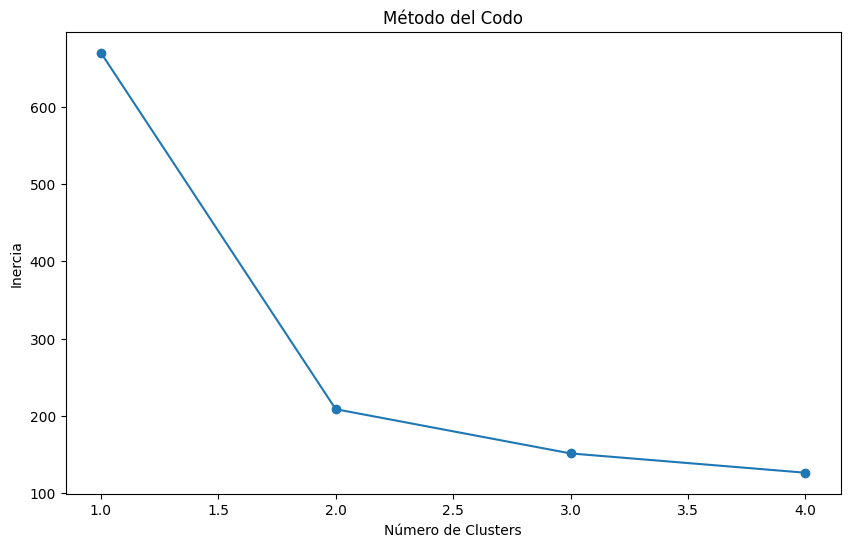

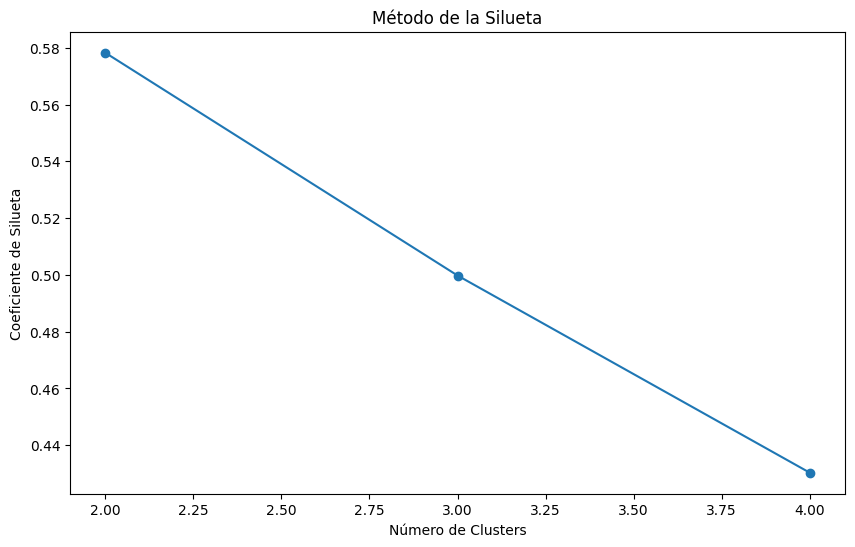

 Número de clusters óptimo:  2


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, max_k):
    """
    Encuentra el número óptimo de clusters utilizando el método del codo.

    Args:
    - data (numpy.ndarray): Los datos de entrada.
    - max_k (int): El número máximo de clusters a probar.

    Returns:
    - optimal_k (int): El número óptimo de clusters.
    """

    # Lista para almacenar los valores de inercia
    inertia_values = []

    # Lista para almacenar los valores de silhouette
    silhouette_scores = []

    for k in range(1, max_k + 1):
        # Entrenar el modelo de KMeans
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)

        # Calcular la inercia y añadirla a la lista
        inertia_values.append(kmeans.inertia_)

        # Calcular el coeficiente de silhouette y añadirlo a la lista
        if k > 1:
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Plot del método del codo
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), inertia_values, marker='o')
    plt.title('Método del Codo')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.show()

    # Plot del método de la silueta
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.title('Método de la Silueta')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Coeficiente de Silueta')
    plt.show()

    # Encontrar el punto de codo
    # En este caso, el punto de codo es donde la derivada segunda de la inercia es máxima
    acceleration = np.diff(inertia_values, 2)  # Derivada segunda de la inercia
    optimal_k = acceleration.argmax() + 2  # El número óptimo de clusters

    return optimal_k


n_clust = find_optimal_clusters (data = mts_representations, max_k = 4)

print (f' Número de clusters óptimo:  {n_clust}')

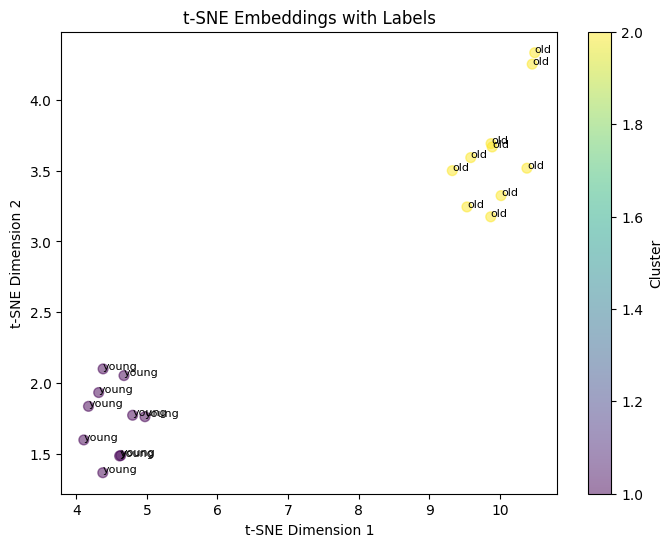

In [ ]:
from sklearn.manifold import TSNE

def plot_tsne_with_labels(data, clusters, labels):
    """
    Realiza la reducción de dimensionalidad con t-SNE y grafica el scatter plot con las etiquetas.

    Args:
    - data (numpy.ndarray): Los datos de entrada.
    - clusters (numpy.ndarray): Las etiquetas de los clústeres.
    - labels (list): Las etiquetas correspondientes a los datos.
    - label_map (dict): Un mapeo de índices de datos a posiciones t-SNE.

    Returns:
    None
    """
    # Reducción de dimensionalidad con t-SNE
    tsne = TSNE (n_components = 2, perplexity = 10, random_state = 0)
    embeddings_tsne = tsne.fit_transform (data)

    # Graficar el scatter plot con las etiquetas
    plt.figure (figsize = (8, 6))
    plt.scatter (embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.5)
    n_subjects = embeddings_tsne.shape [0]
    for idx in range (n_subjects):
        plt.text(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1], labels [idx], fontsize=8)

    plt.title('t-SNE Embeddings with Labels')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(label='Cluster')
    plt.show()

# Llamar a la función con las etiquetas de los puntos y el mapeo
plot_tsne_with_labels(mts_representations, clust, words_labels)

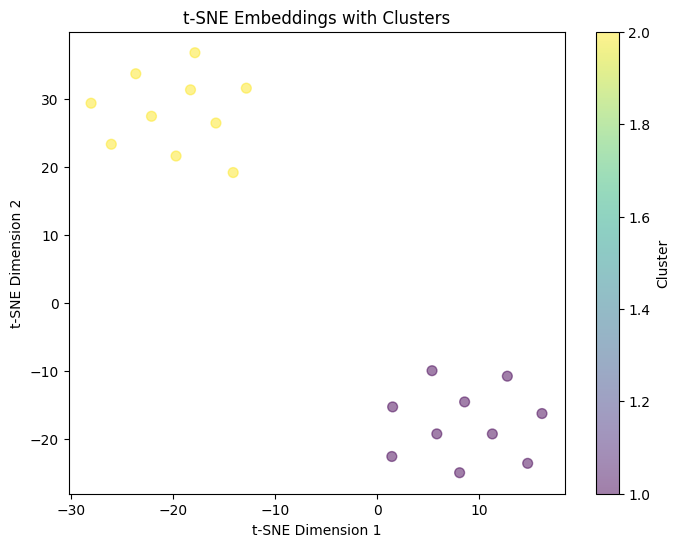

In [ ]:
from sklearn.manifold import TSNE

def plot_tsne_with_clusters (data, clusters):
    """
    Realiza la reducción de dimensionalidad con t-SNE y grafica el scatter plot con los clústeres.

    Args:
    - data (numpy.ndarray): Los datos de entrada.
    - clusters (numpy.ndarray): Las etiquetas de los clústeres.

    Returns:
    None
    """
    tsne = TSNE (n_components = 2, perplexity = 10, random_state = 0)
    embeddings_tsne = tsne.fit_transform (data)

    # Graficar el scatter plot con los clústeres
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.5)
    plt.title('t-SNE Embeddings with Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(label='Cluster')
    plt.show()

#################
mts_representations = my_rc_clus.input_repr
# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity(mts_representations)

plot_tsne_with_clusters (mts_representations, clust)

# Cálculo del coeficiente de silhouette:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


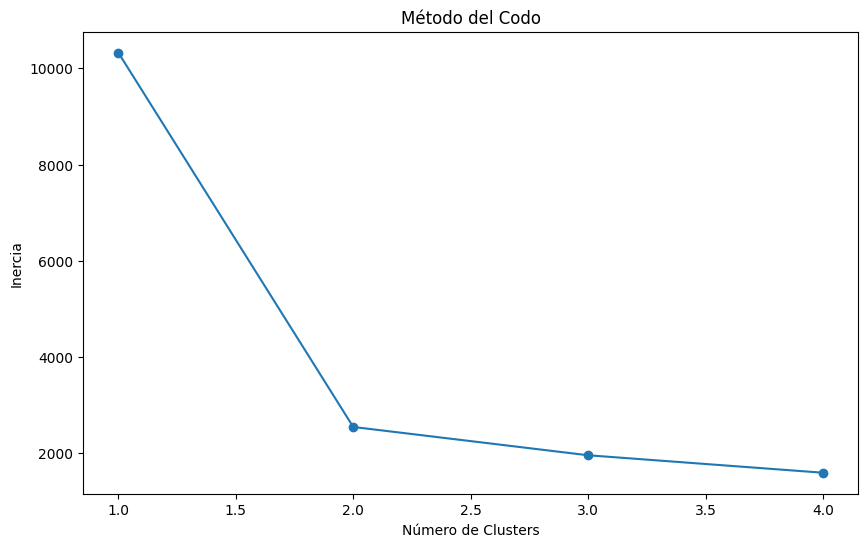

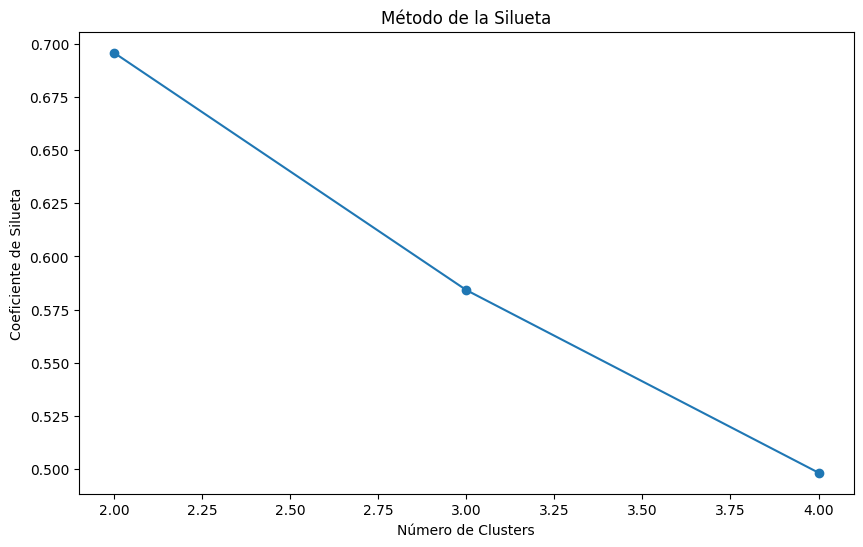

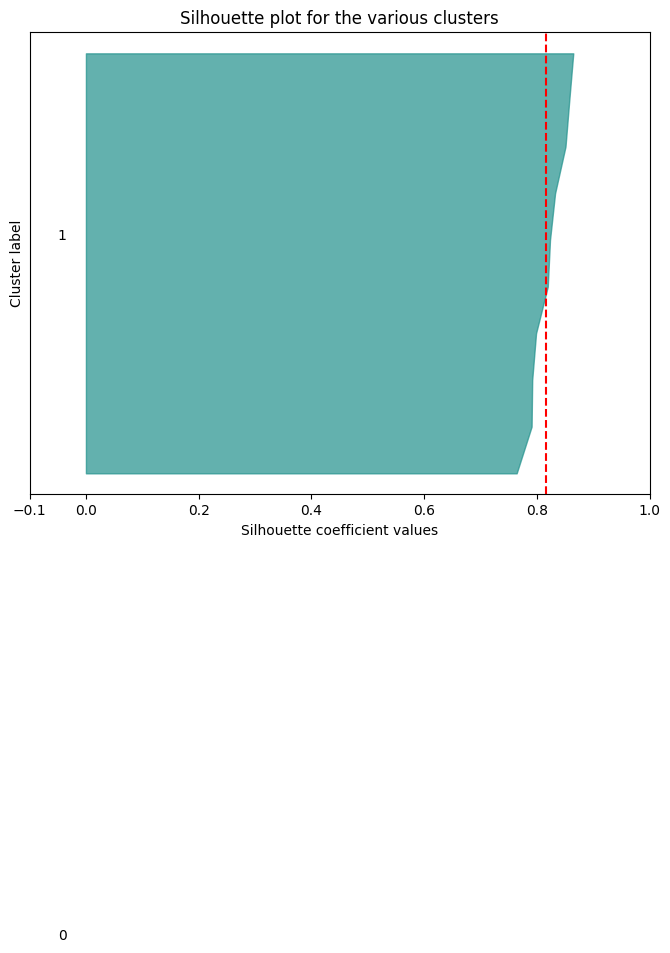

Coeficiente de Silhouette promedio: 0.81658906


0.81658906

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

def create_one_hot_labels (n_samples, n_clusters):
    """
    Crea etiquetas one-hot en función del número de clústeres.

    Args:
    - n_samples (int): El número total de muestras.
    - n_clusters (int): El número de clústeres.

    Returns:
    - labels (numpy.ndarray): Las etiquetas one-hot.
    """

    labels = np.zeros((n_samples, n_clusters), dtype=int)
    for i in range(n_samples):
        cluster_index = np.random.randint(0, n_clusters)  # Elegir aleatoriamente un clúster para cada muestra
        labels[i, cluster_index] = 1  # Establecer la etiqueta one-hot correspondiente al clúster seleccionado

    return labels
def encode(labels_one_hot):
    """
    Convierte las etiquetas codificadas en one-hot al formato 0-1.

    Args:
    - labels_one_hot (numpy.ndarray): Las etiquetas codificadas en one-hot.

    Returns:
    - labels (numpy.ndarray): Las etiquetas en el formato 0-1.
    """
    return np.argmax(labels_one_hot, axis=1)
def calculate_silhouette_score(data, clust,  n_components=2):
    """
    Calcula el coeficiente de silhouette para un conjunto de datos y grafica el coeficiente de silhouette para cada punto agrupado por los clusters.

    Args:
    - data (numpy.ndarray): Los datos de entrada.

    Returns:
    - silhouette_avg (float): El coeficiente de silhouette promedio para todos los puntos.
    """

    # Reducción de dimensionalidad con t-SNE
    tsne = TSNE (n_components = n_components, perplexity = 10, random_state = 0)
    embeddings_tsne = tsne.fit_transform (data)

    # Calcular el número óptimo de clusters usando K-means o cualquier otro algoritmo de clustering
    n_clusters = find_optimal_clusters (data = data, max_k = 4)

    #  asignación de clústeres con jerarquico

    n_samples = data.shape[0]

    clust = clust

    # Calcular el coeficiente de silhouette para cada punto
    silhouette_values = silhouette_samples(embeddings_tsne, clust)

    # Calcular el coeficiente de silhouette promedio para todos los puntos
    silhouette_avg = silhouette_score(embeddings_tsne, clust)

    # Graficar el coeficiente de silhouette
    plt.figure(figsize=(8, 6))
    # Crear una barra horizontal para cada punto
    y_lower = 10
    for i in range(n_clusters):
        # Agregar el coeficiente de silhouette para los puntos en el cluster i
        cluster_silhouette_values = silhouette_values[clust == i]
        cluster_silhouette_values.sort()
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.viridis(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetar el cluster i en el gráfico
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcular el siguiente y_lower para el próximo cluster
        y_lower = y_upper + 10

    plt.title("Silhouette plot for the various clusters")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Línea vertical para el promedio del coeficiente de silhouette
    plt.yticks([])  # Quitar las etiquetas del eje y
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

    print("Coeficiente de Silhouette promedio:", silhouette_avg)

    return silhouette_avg

#############

mts_representations = my_rc_clus.input_repr
calculate_silhouette_score (mts_representations, clust)

# manifolds

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


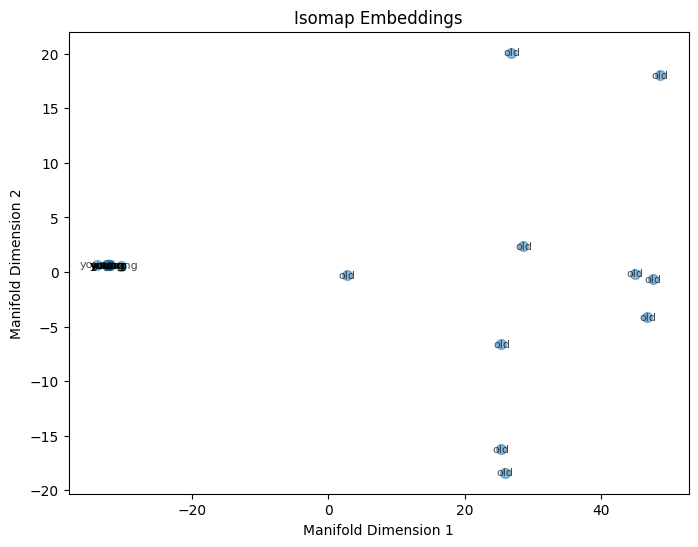

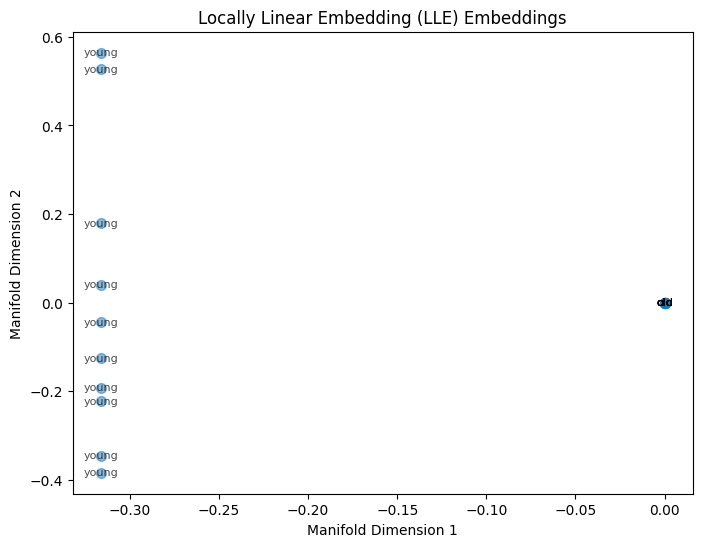

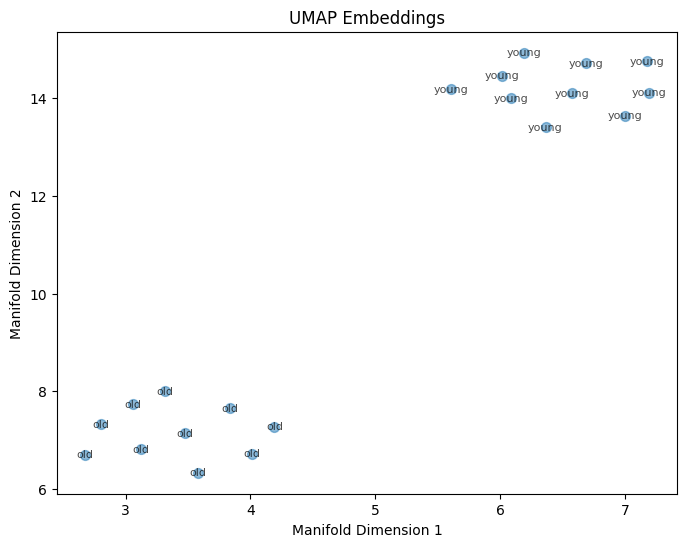

In [ ]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from umap import UMAP
import matplotlib.pyplot as plt

# Función para visualizar los resultados de Manifold Learning con etiquetas
def plot_manifold_learning_with_labels_1 (embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s=50, alpha=0.5)


    # Calcular el centro de los puntos para posicionar las etiquetas
    center_x = embeddings[:, 0].mean()
    center_y = embeddings[:, 1].mean()

    for i, word in enumerate(labels):
        # Calcular el desplazamiento de la etiqueta
        x_offset = embeddings[i, 0] - center_x
        y_offset = embeddings[i, 1] - center_y

        # Posicionar la etiqueta cerca del punto correspondiente
        plt.text(embeddings[i, 0], embeddings[i, 1], word, fontsize=8,
                 horizontalalignment='center', verticalalignment='center',
                 color='black', alpha=0.7, rotation=0,
                 transform=plt.gca().transData)

    plt.title(title)
    plt.xlabel('Manifold Dimension 1')
    plt.ylabel('Manifold Dimension 2')
    plt.show()
# Función para visualizar los resultados de Manifold Learning con etiquetas
def plot_manifold_learning_with_labels (embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s=50, alpha=0.5)

    n_subjects = embeddings.shape [0]
    for i in range (n_subjects):
        # Posicionar la etiqueta cerca del punto correspondiente
        plt.text(embeddings[i, 0], embeddings[i, 1], labels [i], fontsize=8,
                 horizontalalignment='center', verticalalignment='center',
                 color='black', alpha=0.7, rotation=0,
                 transform=plt.gca().transData)

    plt.title(title)
    plt.xlabel('Manifold Dimension 1')
    plt.ylabel('Manifold Dimension 2')
    plt.show()

# Crear un diccionario que mapee índices de datos a posiciones de embeddings
label_map = {idx: idx for idx in range(len(mts_representations))}

##########################
# Aplicar Isomap
isomap = Isomap(n_components=2)
embeddings_isomap = isomap.fit_transform (mts_representations)
# Llamar a la función con las etiquetas de los puntos y las proyecciones de Isomap
plot_manifold_learning_with_labels(embeddings_isomap, words_labels, 'Isomap Embeddings')


# Aplicar Locally Linear Embedding (LLE)
lle = LocallyLinearEmbedding (n_components=2)
embeddings_lle = lle.fit_transform (mts_representations)
# Llamar a la función con las etiquetas de los puntos y las proyecciones de LLE
plot_manifold_learning_with_labels(embeddings_lle, words_labels, 'Locally Linear Embedding (LLE) Embeddings')


# Aplicar Uniform Manifold Approximation and Projection (UMAP)
umap = UMAP (n_components=2)
embeddings_umap = umap.fit_transform(mts_representations)
# Llamar a la función con las etiquetas de los puntos y las proyecciones de UMAP
plot_manifold_learning_with_labels(embeddings_umap, words_labels, 'UMAP Embeddings')

(20, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


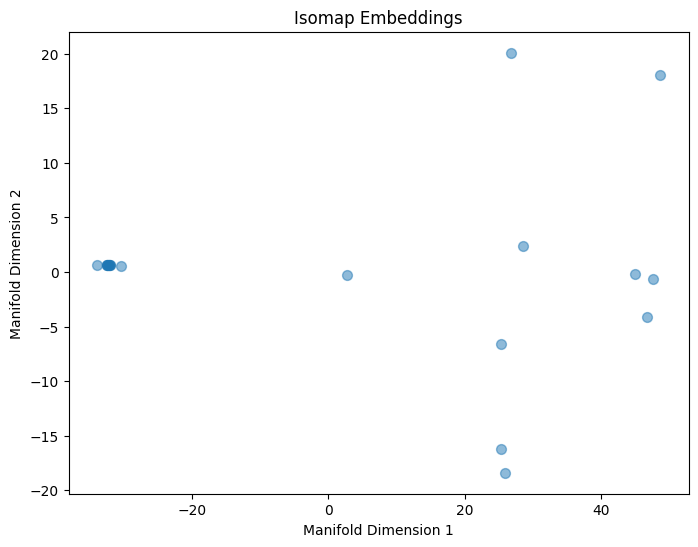

(20, 2)


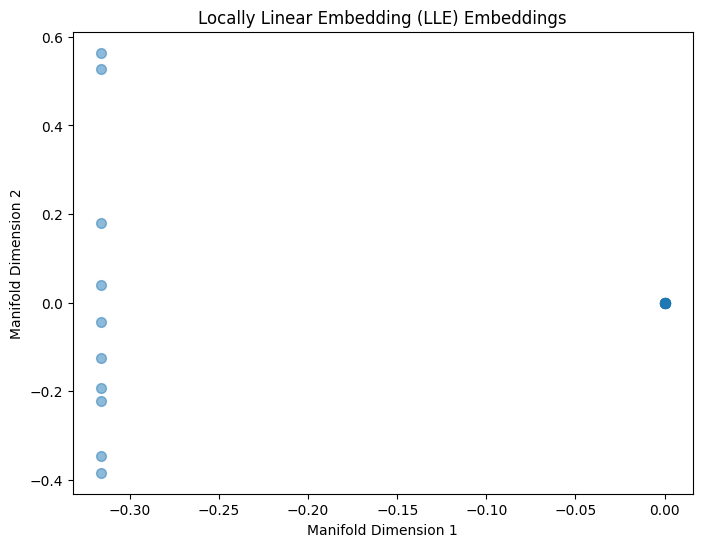

(20, 2)


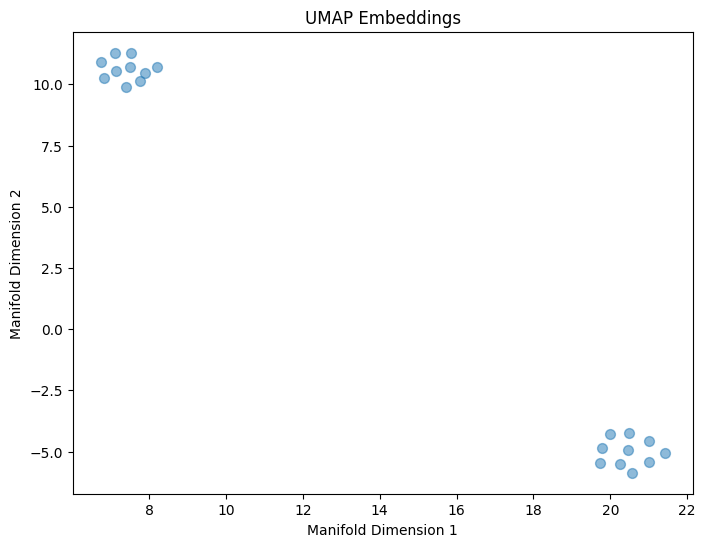

In [ ]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from umap import UMAP
import matplotlib.pyplot as plt

# Función para visualizar los resultados de Manifold Learning
def plot_manifold_learning(embeddings, title):
    print (embeddings.shape)
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s=50, alpha=0.5)
    plt.title(title)
    plt.xlabel('Manifold Dimension 1')
    plt.ylabel('Manifold Dimension 2')
    plt.show()

##########################
# Aplicar Isomap
isomap = Isomap(n_components=2)
embeddings_isomap = isomap.fit_transform (mts_representations)
plot_manifold_learning(embeddings_isomap, 'Isomap Embeddings')

# Aplicar Locally Linear Embedding (LLE)
lle = LocallyLinearEmbedding (n_components=2)
embeddings_lle = lle.fit_transform (mts_representations)
plot_manifold_learning(embeddings_lle, 'Locally Linear Embedding (LLE) Embeddings')

# Aplicar Uniform Manifold Approximation and Projection (UMAP)
umap = UMAP (n_components=2)
embeddings_umap = umap.fit_transform(mts_representations)
plot_manifold_learning(embeddings_umap, 'UMAP Embeddings')


# **Estudio por bandas de frecuencia presentes en las señales del EEG de cada sujeto**

In [108]:
from sklearn.linear_model import Ridge

# Función para realizar la reconstrucción de las señales EEG utilizando regresión Ridge
def reconstruct_eeg_ridge (rc_representation, eeg_data, alpha = 1.0):
    reconstructed_eeg = []
    num_subjects = rc_representation.shape [0]
    print (f' reconstruct_eeg_ridge - rc_representation:{rc_representation.shape}')
    print (f' reconstruct_eeg_ridge - num_subjects:{num_subjects}')
    for i in range(num_subjects):
        print (f' *********** reconstruct_eeg_ridge - subjects:{i} *****************')
        # Ajustar el modelo de regresión Ridge para cada sujeto
        ridge_model      = Ridge (alpha = alpha)
        rc_subject_repre = rc_representation [i]
        eeg_subject_data = eeg_data [i]
        print (f' reconstruct_eeg_ridge - rc_subject_repre:{rc_subject_repre.shape}')
        print (f' reconstruct_eeg_ridge - eeg_subject_data:{eeg_subject_data.shape}')
        ridge_model.fit (rc_subject_repre, eeg_subject_data)

        # Reconstruir las señales EEG
        reconstructed_subject_eeg = ridge_model.predict(rc_representation[i])
        print (f' reconstruct_eeg_ridge - reconstructed_subject_eeg:{reconstructed_subject_eeg.shape}')
        reconstructed_eeg.append(reconstructed_subject_eeg)

    reconstructed_eeg = np.array(reconstructed_eeg)
    return reconstructed_eeg

# Definir el parámetro de regularización (ajusta según sea necesario)
alpha = 0.1



X_orig = Xo
# Si bidireccional, duplicar y concatenar los datos de entrada
if config_clus_o ['bidir']:
    Xo_b = Xo [:, ::-1, :].copy()
    X_orig = np.concatenate((Xo, Xo_b), axis=1)
    n_samples = X_orig.shape[1]


psd_rec  = []
bd_frec  = []
# Reconstruir las señales EEG utilizando regresión Ridge
mts_representation = reservoir_state_o
print (f' X_orig :{X_orig.shape}')
print (f' mts_representation :{mts_representation.shape}')
reconstructed_eeg_ridge = reconstruct_eeg_ridge (mts_representation, X_orig, alpha = alpha)
print (f' 1 reconstructed_eeg_ridge  :{reconstructed_eeg_ridge.shape}')


 X_orig :(20, 2000, 10)
 mts_representation :(20, 2000, 480)
 reconstruct_eeg_ridge - rc_representation:(20, 2000, 480)
 reconstruct_eeg_ridge - num_subjects:20
 *********** reconstruct_eeg_ridge - subjects:0 *****************
 reconstruct_eeg_ridge - rc_subject_repre:(2000, 480)
 reconstruct_eeg_ridge - eeg_subject_data:(2000, 10)
 reconstruct_eeg_ridge - reconstructed_subject_eeg:(2000, 10)
 *********** reconstruct_eeg_ridge - subjects:1 *****************
 reconstruct_eeg_ridge - rc_subject_repre:(2000, 480)
 reconstruct_eeg_ridge - eeg_subject_data:(2000, 10)
 reconstruct_eeg_ridge - reconstructed_subject_eeg:(2000, 10)
 *********** reconstruct_eeg_ridge - subjects:2 *****************
 reconstruct_eeg_ridge - rc_subject_repre:(2000, 480)
 reconstruct_eeg_ridge - eeg_subject_data:(2000, 10)
 reconstruct_eeg_ridge - reconstructed_subject_eeg:(2000, 10)
 *********** reconstruct_eeg_ridge - subjects:3 *****************
 reconstruct_eeg_ridge - rc_subject_repre:(2000, 480)
 reconstruct_e

 num_subjects  : 20
 *********** Densidad Potencia - subjects:0 *****************
  Densidad Potencia - eeg_reconstructed:(2000, 10)  
  Densidad Potencia - frequencies_reconstructed: (6,)  
  Densidad Potencia - psd_reconstructed:(2000, 6)  


/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  warnings.warn('nperseg = {0:d} is greater than input length '


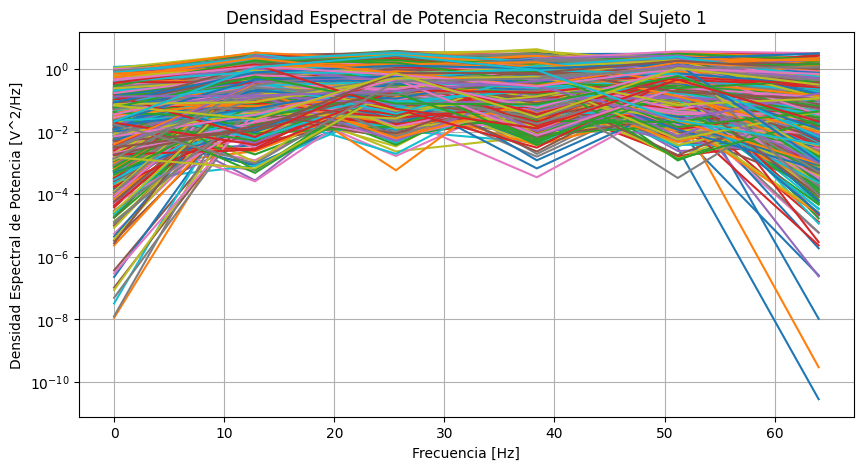

 *********** Densidad Potencia - subjects:1 *****************
  Densidad Potencia - eeg_reconstructed:(2000, 10)  
  Densidad Potencia - frequencies_reconstructed: (6,)  
  Densidad Potencia - psd_reconstructed:(2000, 6)  


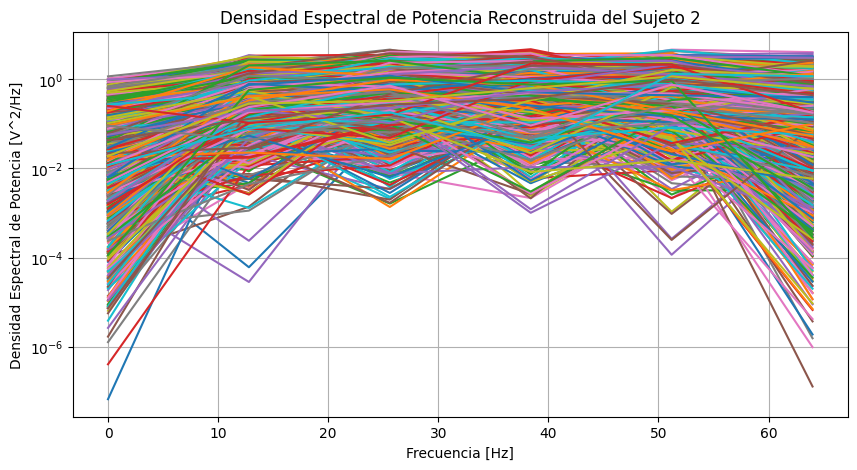

 *********** Densidad Potencia - subjects:2 *****************
  Densidad Potencia - eeg_reconstructed:(2000, 10)  
  Densidad Potencia - frequencies_reconstructed: (6,)  
  Densidad Potencia - psd_reconstructed:(2000, 6)  


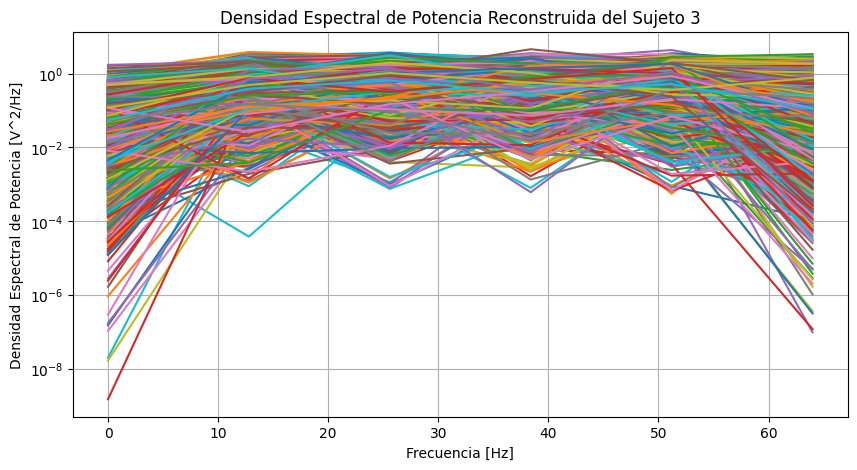

 *********** Densidad Potencia - subjects:3 *****************
  Densidad Potencia - eeg_reconstructed:(2000, 10)  
  Densidad Potencia - frequencies_reconstructed: (6,)  
  Densidad Potencia - psd_reconstructed:(2000, 6)  


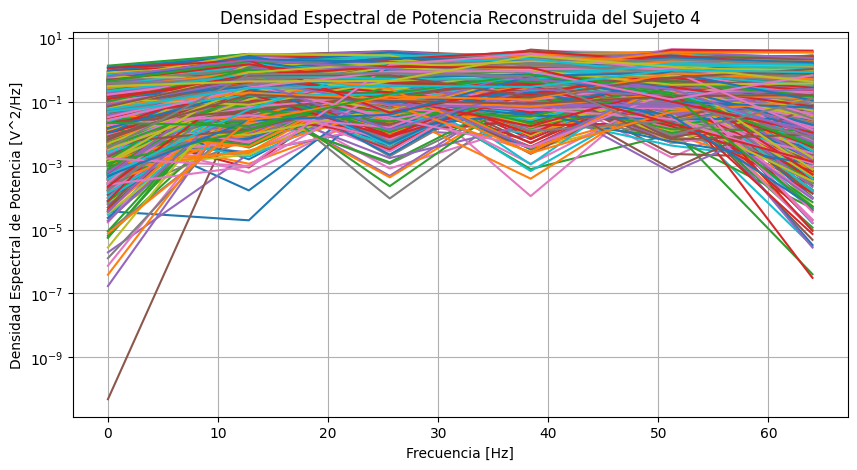

 *********** Densidad Potencia - subjects:4 *****************
  Densidad Potencia - eeg_reconstructed:(2000, 10)  
  Densidad Potencia - frequencies_reconstructed: (6,)  
  Densidad Potencia - psd_reconstructed:(2000, 6)  


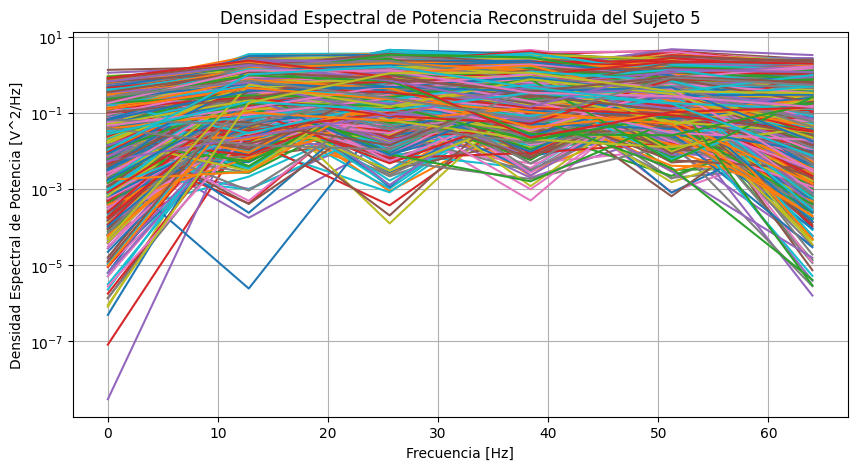

In [ ]:
# Paso 2: Análisis de las Ondas EEG Reconstruidas
# Calcular la densidad espectral de potencia para las señales EEG reconstruidas
fs = 512//4  # Frecuencia de muestreo de los datos EEG
num_subjects = mts_representation.shape [0]
print (f' num_subjects  : {num_subjects}')
psd_rec = []
bd_frec = []
for i in range (num_subjects):
    print (f' *********** Densidad Potencia - subjects:{i} *****************')
    plt.figure (figsize = (10, 5))

    # Obtener las señales EEG reconstruidas para el sujeto actual
    eeg_reconstructed = reconstructed_eeg_ridge [i]
    print (f'  Densidad Potencia - eeg_reconstructed:{eeg_reconstructed.shape}  ')
    # Calcular la densidad espectral de potencia para las señales EEG reconstruidas
    frequencies_reconstructed, psd_reconstructed = welch (eeg_reconstructed, fs = fs, nperseg = 256)

    print (f'  Densidad Potencia - frequencies_reconstructed: {frequencies_reconstructed.shape}  ')
    print (f'  Densidad Potencia - psd_reconstructed:{psd_reconstructed.shape}  ')
    psd_rec.append (psd_reconstructed)
    bd_frec.append (frequencies_reconstructed)
    # Trazar la PSD para las señales EEG reconstruidas
    plt.semilogy(frequencies_reconstructed, psd_reconstructed.T)

    plt.title(f'Densidad Espectral de Potencia Reconstruida del Sujeto {i+1}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad Espectral de Potencia [V^2/Hz]')
    plt.grid(True)
    plt.show()



In [ ]:
# Paso 3:
print(f' psd_rec:{len(psd_rec)} ')
print(f' psd_rec:{psd_rec[0].shape} ')
print(f' bd_frec:{len(bd_frec)} ')

# Establecer las bandas de frecuencia
b_frequencies = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 100)
}

# Initialize a dictionary to store wave percentage by frequency band per subject
wave_percentage_per_subject = {}

# Calculate the percentage of power for each frequency band relative to total power for each subject
for i in range(num_subjects):
    print(f'Subject:{i}')
    # Calculate total power in each reconstructed EEG signal
    total_power = np.sum(psd_rec[i], axis=1)
    subject_power = psd_rec[i]

    frequencies_reconstructed = bd_frec [i]
    print(f'subject_power:{subject_power.shape}')
    print(f'frequencies_reconstructed:{frequencies_reconstructed.shape}')
    percentage_waves_subject = {}
    for band, (start, end) in b_frequencies.items():
        # Find indices of frequencies within the band range
        band_indices = np.where((frequencies_reconstructed >= start) & (frequencies_reconstructed < end))[0]

        # Sum power in the frequency band
        band_power = np.sum(subject_power[:, band_indices])

        # Calculate percentage of power in the frequency band
        percentage_band = band_power / total_power[i] if total_power[i] > 0 else 0

        # Store percentage power in dictionary by band
        percentage_waves_subject[band] = percentage_band
    wave_percentage_per_subject[i] = percentage_waves_subject

# Print wave percentages by frequency band per subject
for i, percentages in wave_percentage_per_subject.items():
    print(f"Subject {i + 1}:")
    for band, percentage in percentages.items():
        print(f"- {band}: {percentage * 100:.2f}%")

 psd_rec:20 
 psd_rec:(2000, 6) 
 bd_frec:20 
Subject:0
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:1
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:2
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:3
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:4
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:5
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:6
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:7
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:8
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:9
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:10
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:11
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:12
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:13
subject_power:(2000, 6)
frequencies_reconstructed:(6,)
Subject:14
subject_power:(2000, 6)
frequ

psd_array:(120, 2000, 6)


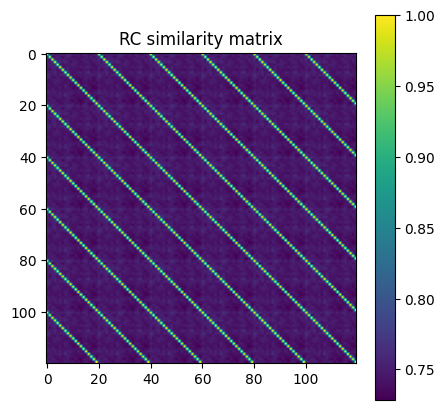

ValueError: 'c' argument has 20 elements, which is inconsistent with 'x' and 'y' with size 120.

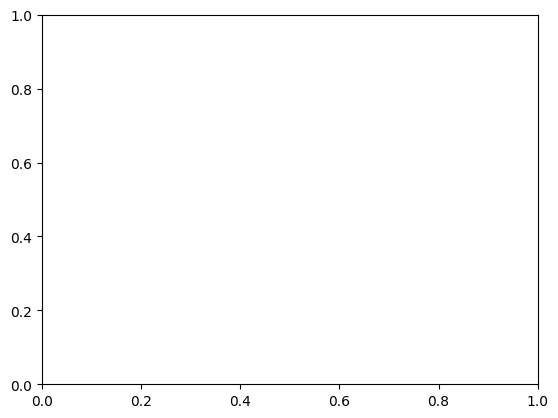

In [ ]:
# General imports
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score

# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)
psd_array = np.array(psd_rec)
print(f'psd_array:{psd_array.shape}')
flattened_array = psd_array.reshape(psd_array.shape[0], -1)
mts_representations = flattened_array
# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity(mts_representations)

# Normalize the similarity in [0,1]
similarity_matrix = (similarity_matrix + 1.0)/2.0

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

# Dimensionality reduction with Kernel PCA
kpca = KernelPCA(n_components = 4, kernel='precomputed')
embeddings_pca = kpca.fit_transform(similarity_matrix)
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y[:,0], s=3)
plt.title("PCA embeddings")
plt.show()

# Compute Dissimilarity matrix
Dist = 1.0 - similarity_matrix
np.fill_diagonal(Dist, 0) # due to numerical errors, the diagonal might not be 0

# Hierarchical clustering
distArray = ssd.squareform(Dist)
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t=2.0, criterion="distance")
print("Found %d clusters"%len(np.unique(clust)))

# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print("Normalized Mutual Information (v-score): %.3f"%nmi)

# Plot dendrogram
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=0.03, labels=words_labels, above_threshold_color='k')
plt.show()
print("N. clusters: ", np.unique(dn['color_list']).shape[0]-1)

# Classi

/content/drive/MyDrive/eeg_data/base/MyRC_ESN.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.reservoir_weights  = torch.tensor (self.reservoir_weights)


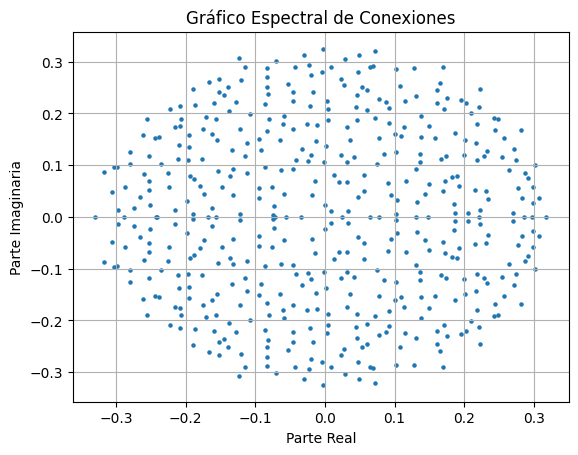

In [ ]:
#

config  = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.1,
    'init_mean':0,
    'input_size':10,
    'n_internal_units': 480,
    'spectral_radius': 0.59,
    'leak': 0.4,
    'input_scaling':1.0,
    'nonlinearity':'tanh',
    'connectivity': 0.3,
    'input_scaling': 0.1,
    'noise_level': 0.01,
    'n_drop': 'all',
    'use_input_bias':True,
    'use_input_layer':True,
    'use_output_bias':True,
    'use_bias':True,
    'readout_type': 'lin',
    'threshold':0.5,
    'readout_training': 'gd',
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'num_epochs': 2000,
    'mlp_layout': (10, 10),
    'w_l2': 0.001,
    'nonlinearity': 'relu',
    'learning_rate':0.9,
    'max_depth':12,
    'n_estimators':100,
    'min_samples_split':1,
    'min_samples_leaf':1,
    'random_state':1,
    'w_ridge_embedding':10.0,
    'mts_rep':'reservoir',
    'bidir': True,
    'circ': False,
    'dimred_method': 'tenpca',
    'n_dim': 90
}

model = MyESN (config)

# Llamar al método para trazar el gráfico espectral
model.plot_spectral_graph ()

In [ ]:
# Dividir los sujetos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(synthetic_data, labels, test_size=0.2, random_state=42)

print("Dimensiones de los datos de entrenamiento:", X_train.shape)
print("Dimensiones de las etiquetas de entrenamiento:", y_train.shape)
print("Dimensiones de los datos de prueba:", X_test.shape)
print("Dimensiones de las etiquetas de prueba:", y_test.shape)

Dimensiones de los datos de entrenamiento: (32, 6000, 10)
Dimensiones de las etiquetas de entrenamiento: (32, 2)
Dimensiones de los datos de prueba: (8, 6000, 10)
Dimensiones de las etiquetas de prueba: (8, 2)


In [ ]:
# Instanciar un objeto MyRC
my_rc = MyRC(model, config)

# Entrenar el modelo
output_rc_layer, reservoir_state, mtx_rc_state, red_states = my_rc.fit (X_train, y_train)

* self.mts_rep : reservoir
* _process_transient_ESN : n_sample process 0/6000
* _process_transient_ESN : n_sample process 10/6000
* _process_transient_ESN : n_sample process 20/6000
* _process_transient_ESN : n_sample process 30/6000
* _process_transient_ESN : n_sample process 40/6000
* _process_transient_ESN : n_sample process 50/6000
* _process_transient_ESN : n_sample process 60/6000
* _process_transient_ESN : n_sample process 70/6000
* _process_transient_ESN : n_sample process 80/6000
* _process_transient_ESN : n_sample process 90/6000
* _process_transient_ESN : n_sample process 100/6000
* _process_transient_ESN : n_sample process 110/6000
* _process_transient_ESN : n_sample process 120/6000
* _process_transient_ESN : n_sample process 130/6000
* _process_transient_ESN : n_sample process 140/6000
* _process_transient_ESN : n_sample process 150/6000
* _process_transient_ESN : n_sample process 160/6000
* _process_transient_ESN : n_sample process 170/6000
* _process_transient_ESN : n_s

In [ ]:
## X_train debe ser el conjunto de vectores de características del Reservoir Computing
# y_train deben ser los labels para X_train

pred_class, f1,  c_matrix = my_rc.fit_evaluate (X_test, y_test)
##
print ('* c_matrix :', c_matrix)
print ('* f1 :', f1)
print ('* pred_class :', pred_class)
print (f' ************** FIN CLASIFICACION  ************************************')

* _process_transient_ESN : n_sample process 0/6000
* _process_transient_ESN : n_sample process 10/6000
* _process_transient_ESN : n_sample process 20/6000
* _process_transient_ESN : n_sample process 30/6000
* _process_transient_ESN : n_sample process 40/6000
* _process_transient_ESN : n_sample process 50/6000
* _process_transient_ESN : n_sample process 60/6000
* _process_transient_ESN : n_sample process 70/6000
* _process_transient_ESN : n_sample process 80/6000
* _process_transient_ESN : n_sample process 90/6000
* _process_transient_ESN : n_sample process 100/6000
* _process_transient_ESN : n_sample process 110/6000
* _process_transient_ESN : n_sample process 120/6000
* _process_transient_ESN : n_sample process 130/6000
* _process_transient_ESN : n_sample process 140/6000
* _process_transient_ESN : n_sample process 150/6000
* _process_transient_ESN : n_sample process 160/6000
* _process_transient_ESN : n_sample process 170/6000
* _process_transient_ESN : n_sample process 180/6000
* _p

# Uso valores cantidad energia en cada banda


- si se observan **valores altos de onda delta junto con valores bajos en otras bandas** de frecuencia, podría indicar un **estado de reposo o sueño**, mientras que una **distribución más equilibrada de energía entre diferentes bandas podría indicar actividad mental**.

- La **onda alfa** está relacionada con la **falta de actividad cerebral** (Blasi & Roig). Es una onda con una frecuencia de entre 8-12 Hz. Cuando una persona toma un **descanso después de una actividad o cuando medita o da un paseo**, se originan ondas alfa.  

- las **ondas beta** se generan cuando el **cerebro está activo y concentrado en actividades mentales**, genera . Este tipo de ondas son de una amplitud más baja y una frecuencia de entre 12-30 Hz. Por ejemplo, durante una conversación intensa o un debate, o dando una clase un profesor, se genera la onda beta.

- las **ondas theta** se emiten cuando un individuo está tan relajado que comienza a soñar despierto,  . Estas ondas surgen, por ejemplo, cuando se lleva un rato conduciendo y resulta imposible recordar los últimos kilómetros recorridos, es decir, **durante esas actividades que realizamos automáticamente**, como ducharse. Las ondas theta tienen una frecuencia de entre 4-8 Hz. Este estado mental es muy positivo para la **generación de ideas**.

- las **ondas delta** se originan en el momento de **sueño profundo**. Son las ondas de menor frecuencia, entre 0,5-4 Hz. Cuando se apaga la luz y se cierran los ojos para dormir, las ondas cerebrales descienden en frecuencia hasta la onda delta, en la que se alcanza el sueño profundo (Herrmann, 1990)

- La **onda gamma** es la más rápida, con frecuencias de 30-42 Hz. Esta onda a menudo se ha señalado como especialmente relevante para la **conciencia** (YuvalGreenberg, Tomer, Keren, Nelken, & Deouell, 2008) y relacionada con **experiencias de meditación** (Braboszcz, Cahn, Levy, Fernandez, & Delorme, 2017).



|onda| freceuncia |  estado|
|-----|-----------|---------|
|Delta	|1–4 |	Sueño, reparación, resolución de problemas complejos, inconsciencia, profunda inconsciencia |
|Theta	|4–8 |	Creatividad, percepción, estados profundos, inconsciencia, estado meditativo óptimo, depresión, ansiedad, distracción |
|Alpha	|8–13 |	Alerta y tranquilidad, preparación, meditación, profundamente relajado.
|Alpha inferior	|8–10 |	Recordando |
|Alpha superior	|10–13 |	Optimizar el rendimiento cognitivo. SMR (ritmo sensoriomoto)	13–15	Estado de alerta mental, relajación física |
|Beta	|15–20 |	 Pensar, enfocar, atención sostenida, tensión, estado de alerta, emoción. |
|Beta alto	|20-32 |	Intensidad, estado de hiperalerta, ansiedad. |
|Gamma	|32–100 |	Aprendizaje, procesamiento cognitivo, tareas de resolución de problemas, agudeza mental, actividad cerebral, organización del cerebro. |


In [ ]:
import numpy as np
bandas_frecuencia = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 100)
    }
# Definir los valores para cada sujeto
sujetos = {
    1: [31856087.50, 5451.81, 5451.80, 24533.07, 46340.29],
    2: [10104617.19, 1729.29, 1729.29, 7781.79, 14698.94],
    3: [875181.64, 149.78, 149.78, 674.00, 1273.11],
    4: [415708.94, 71.14, 71.14, 320.15, 604.72],
    5: [212317.07, 36.34, 36.34, 163.51, 308.85],
    6: [1274546.97, 218.12, 218.12, 981.56, 1854.05],
    7: [1231136.62, 210.70, 210.69, 948.13, 1790.91],
    8: [2317185.55, 396.56, 396.56, 1784.52, 3370.75]
}

# Crear el dataset X y asignar etiquetas
X = []
y = []
for sujeto, valores in sujetos.items():
    X.append(valores)
    if sujeto <= 4:
        y.append(0)  # Etiqueta 0 para sujetos jóvenes
    else:
        y.append(1)  # Etiqueta 1 para sujetos mayores

# Convertir a matrices numpy
X = np.array(X)
y = np.array(y)

print("Dataset X:")
print(X)
print("Etiquetas y:")
print(y)


Dataset X:
[[3.18560875e+07 5.45181000e+03 5.45180000e+03 2.45330700e+04
  4.63402900e+04]
 [1.01046172e+07 1.72929000e+03 1.72929000e+03 7.78179000e+03
  1.46989400e+04]
 [8.75181640e+05 1.49780000e+02 1.49780000e+02 6.74000000e+02
  1.27311000e+03]
 [4.15708940e+05 7.11400000e+01 7.11400000e+01 3.20150000e+02
  6.04720000e+02]
 [2.12317070e+05 3.63400000e+01 3.63400000e+01 1.63510000e+02
  3.08850000e+02]
 [1.27454697e+06 2.18120000e+02 2.18120000e+02 9.81560000e+02
  1.85405000e+03]
 [1.23113662e+06 2.10700000e+02 2.10690000e+02 9.48130000e+02
  1.79091000e+03]
 [2.31718555e+06 3.96560000e+02 3.96560000e+02 1.78452000e+03
  3.37075000e+03]]
Etiquetas y:
[0 0 0 0 1 1 1 1]


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 42)

# Inicializar el clasificador SVM
svm_classifier = SVC (kernel='linear', random_state = 42)  # Selecciona el tipo de kernel según tus necesidades (lineal, RBF, polinómico, etc.)

# Entrenar el clasificador SVM
svm_classifier.fit (X_train, y_train)

# Predecir las etiquetas de clase para los datos de prueba
y_pred = svm_classifier.predict (X_test)

# Calcular la precisión del clasificador
accuracy = accuracy_score (y_test, y_pred)
print("Precisión del clasificador SVM:", accuracy)